In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2218485, 828)
(2218485, 1)
validation
(242003, 828)
(242003, 1)
test
(221567, 828)
(221567, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/222 [..............................] - ETA: 4:38 - loss: 0.1237 - STD: 1.4174e-04 - MAE: 0.2987

  4/222 [..............................] - ETA: 3s - loss: 0.0928 - STD: 5.4900e-04 - MAE: 0.2496  

  8/222 [>.............................] - ETA: 3s - loss: 0.0827 - STD: 8.6895e-04 - MAE: 0.2383

 11/222 [>.............................] - ETA: 3s - loss: 0.0804 - STD: 0.0011 - MAE: 0.2388    

 14/222 [>.............................] - ETA: 3s - loss: 0.0777 - STD: 0.0013 - MAE: 0.2365

 17/222 [=>............................] - ETA: 3s - loss: 0.0763 - STD: 0.0015 - MAE: 0.2343

 21/222 [=>............................] - ETA: 3s - loss: 0.0745 - STD: 0.0018 - MAE: 0.2318

 24/222 [==>...........................] - ETA: 3s - loss: 0.0734 - STD: 0.0021 - MAE: 0.2310

 27/222 [==>...........................] - ETA: 3s - loss: 0.0726 - STD: 0.0025 - MAE: 0.2305

 30/222 [===>..........................] - ETA: 3s - loss: 0.0719 - STD: 0.0029 - MAE: 0.2297

 33/222 [===>..........................] - ETA: 3s - loss: 0.0713 - STD: 0.0033 - MAE: 0.2290

 36/222 [===>..........................] - ETA: 3s - loss: 0.0707 - STD: 0.0040 - MAE: 0.2282

 39/222 [====>.........................] - ETA: 3s - loss: 0.0701 - STD: 0.0049 - MAE: 0.2275

 42/222 [====>.........................] - ETA: 3s - loss: 0.0695 - STD: 0.0061 - MAE: 0.2268

 45/222 [=====>........................] - ETA: 3s - loss: 0.0689 - STD: 0.0076 - MAE: 0.2260

 48/222 [=====>........................] - ETA: 3s - loss: 0.0682 - STD: 0.0097 - MAE: 0.2248

 51/222 [=====>........................] - ETA: 3s - loss: 0.0675 - STD: 0.0125 - MAE: 0.2237

 54/222 [======>.......................] - ETA: 2s - loss: 0.0666 - STD: 0.0161 - MAE: 0.2222

 57/222 [======>.......................] - ETA: 2s - loss: 0.0658 - STD: 0.0203 - MAE: 0.2206

 60/222 [=======>......................] - ETA: 2s - loss: 0.0650 - STD: 0.0249 - MAE: 0.2190

 63/222 [=======>......................] - ETA: 2s - loss: 0.0642 - STD: 0.0295 - MAE: 0.2174

 66/222 [=======>......................] - ETA: 2s - loss: 0.0635 - STD: 0.0338 - MAE: 0.2158

 69/222 [========>.....................] - ETA: 2s - loss: 0.0628 - STD: 0.0377 - MAE: 0.2142

 72/222 [========>.....................] - ETA: 2s - loss: 0.0621 - STD: 0.0414 - MAE: 0.2127

 75/222 [=========>....................] - ETA: 2s - loss: 0.0615 - STD: 0.0452 - MAE: 0.2113

 78/222 [=========>....................] - ETA: 2s - loss: 0.0609 - STD: 0.0489 - MAE: 0.2100

 81/222 [=========>....................] - ETA: 2s - loss: 0.0603 - STD: 0.0525 - MAE: 0.2087

 84/222 [==========>...................] - ETA: 2s - loss: 0.0598 - STD: 0.0558 - MAE: 0.2074

 87/222 [==========>...................] - ETA: 3s - loss: 0.0593 - STD: 0.0587 - MAE: 0.2062

 90/222 [===========>..................] - ETA: 3s - loss: 0.0588 - STD: 0.0615 - MAE: 0.2051

 93/222 [===========>..................] - ETA: 3s - loss: 0.0583 - STD: 0.0642 - MAE: 0.2040

 97/222 [============>.................] - ETA: 3s - loss: 0.0576 - STD: 0.0678 - MAE: 0.2025

100/222 [============>.................] - ETA: 2s - loss: 0.0571 - STD: 0.0704 - MAE: 0.2015

103/222 [============>.................] - ETA: 2s - loss: 0.0566 - STD: 0.0728 - MAE: 0.2004

106/222 [=============>................] - ETA: 2s - loss: 0.0560 - STD: 0.0750 - MAE: 0.1992

110/222 [=============>................] - ETA: 2s - loss: 0.0553 - STD: 0.0779 - MAE: 0.1977

113/222 [==============>...............] - ETA: 2s - loss: 0.0547 - STD: 0.0801 - MAE: 0.1964

116/222 [==============>...............] - ETA: 2s - loss: 0.0541 - STD: 0.0824 - MAE: 0.1951

119/222 [===============>..............] - ETA: 2s - loss: 0.0535 - STD: 0.0848 - MAE: 0.1937

122/222 [===============>..............] - ETA: 2s - loss: 0.0530 - STD: 0.0873 - MAE: 0.1925

126/222 [================>.............] - ETA: 2s - loss: 0.0524 - STD: 0.0904 - MAE: 0.1910

128/222 [================>.............] - ETA: 2s - loss: 0.0521 - STD: 0.0919 - MAE: 0.1902

131/222 [================>.............] - ETA: 2s - loss: 0.0516 - STD: 0.0941 - MAE: 0.1890

134/222 [=================>............] - ETA: 2s - loss: 0.0511 - STD: 0.0963 - MAE: 0.1878

137/222 [=================>............] - ETA: 1s - loss: 0.0506 - STD: 0.0983 - MAE: 0.1866

140/222 [=================>............] - ETA: 1s - loss: 0.0501 - STD: 0.1001 - MAE: 0.1854

143/222 [==================>...........] - ETA: 1s - loss: 0.0497 - STD: 0.1019 - MAE: 0.1843

146/222 [==================>...........] - ETA: 1s - loss: 0.0492 - STD: 0.1038 - MAE: 0.1831

149/222 [===================>..........] - ETA: 1s - loss: 0.0487 - STD: 0.1056 - MAE: 0.1820

152/222 [===================>..........] - ETA: 1s - loss: 0.0483 - STD: 0.1073 - MAE: 0.1809

155/222 [===================>..........] - ETA: 1s - loss: 0.0479 - STD: 0.1090 - MAE: 0.1799

159/222 [====================>.........] - ETA: 1s - loss: 0.0473 - STD: 0.1113 - MAE: 0.1785

163/222 [=====================>........] - ETA: 1s - loss: 0.0468 - STD: 0.1135 - MAE: 0.1771

166/222 [=====================>........] - ETA: 1s - loss: 0.0464 - STD: 0.1150 - MAE: 0.1761

169/222 [=====================>........] - ETA: 1s - loss: 0.0460 - STD: 0.1166 - MAE: 0.1751

172/222 [======================>.......] - ETA: 1s - loss: 0.0456 - STD: 0.1181 - MAE: 0.1742

175/222 [======================>.......] - ETA: 1s - loss: 0.0452 - STD: 0.1196 - MAE: 0.1732

178/222 [=======================>......] - ETA: 0s - loss: 0.0449 - STD: 0.1210 - MAE: 0.1723

181/222 [=======================>......] - ETA: 0s - loss: 0.0445 - STD: 0.1224 - MAE: 0.1714

184/222 [=======================>......] - ETA: 0s - loss: 0.0442 - STD: 0.1237 - MAE: 0.1706

188/222 [========================>.....] - ETA: 0s - loss: 0.0437 - STD: 0.1254 - MAE: 0.1694

191/222 [========================>.....] - ETA: 0s - loss: 0.0434 - STD: 0.1266 - MAE: 0.1686

194/222 [=========================>....] - ETA: 0s - loss: 0.0431 - STD: 0.1279 - MAE: 0.1678

197/222 [=========================>....] - ETA: 0s - loss: 0.0428 - STD: 0.1291 - MAE: 0.1670

200/222 [==========================>...] - ETA: 0s - loss: 0.0425 - STD: 0.1302 - MAE: 0.1663

203/222 [==========================>...] - ETA: 0s - loss: 0.0422 - STD: 0.1313 - MAE: 0.1655

206/222 [==========================>...] - ETA: 0s - loss: 0.0419 - STD: 0.1323 - MAE: 0.1648

209/222 [===========================>..] - ETA: 0s - loss: 0.0416 - STD: 0.1334 - MAE: 0.1641

212/222 [===========================>..] - ETA: 0s - loss: 0.0414 - STD: 0.1344 - MAE: 0.1634

215/222 [============================>.] - ETA: 0s - loss: 0.0411 - STD: 0.1354 - MAE: 0.1627

218/222 [============================>.] - ETA: 0s - loss: 0.0408 - STD: 0.1363 - MAE: 0.1621

221/222 [============================>.] - ETA: 0s - loss: 0.0406 - STD: 0.1373 - MAE: 0.1614

222/222 [==============================] - 7s 25ms/step - loss: 0.0405 - STD: 0.1377 - MAE: 0.1612 - val_loss: 0.0182 - val_STD: 0.1075 - val_MAE: 0.1022


Epoch 2/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0224 - STD: 0.1942 - MAE: 0.1168

  4/222 [..............................] - ETA: 3s - loss: 0.0212 - STD: 0.2042 - MAE: 0.1122 

  7/222 [..............................] - ETA: 3s - loss: 0.0211 - STD: 0.2073 - MAE: 0.1113

 10/222 [>.............................] - ETA: 3s - loss: 0.0207 - STD: 0.2083 - MAE: 0.1103

 13/222 [>.............................] - ETA: 3s - loss: 0.0207 - STD: 0.2083 - MAE: 0.1103

 16/222 [=>............................] - ETA: 3s - loss: 0.0206 - STD: 0.2092 - MAE: 0.1100

 19/222 [=>............................] - ETA: 3s - loss: 0.0206 - STD: 0.2100 - MAE: 0.1098

 22/222 [=>............................] - ETA: 3s - loss: 0.0206 - STD: 0.2099 - MAE: 0.1099

 25/222 [==>...........................] - ETA: 3s - loss: 0.0205 - STD: 0.2104 - MAE: 0.1095

 28/222 [==>...........................] - ETA: 3s - loss: 0.0205 - STD: 0.2103 - MAE: 0.1095

 31/222 [===>..........................] - ETA: 3s - loss: 0.0204 - STD: 0.2107 - MAE: 0.1093

 34/222 [===>..........................] - ETA: 3s - loss: 0.0203 - STD: 0.2107 - MAE: 0.1091

 37/222 [====>.........................] - ETA: 3s - loss: 0.0203 - STD: 0.2106 - MAE: 0.1091

 40/222 [====>.........................] - ETA: 3s - loss: 0.0204 - STD: 0.2110 - MAE: 0.1093

 43/222 [====>.........................] - ETA: 3s - loss: 0.0204 - STD: 0.2108 - MAE: 0.1091

 46/222 [=====>........................] - ETA: 3s - loss: 0.0203 - STD: 0.2107 - MAE: 0.1090

 49/222 [=====>........................] - ETA: 3s - loss: 0.0202 - STD: 0.2108 - MAE: 0.1089

 53/222 [======>.......................] - ETA: 2s - loss: 0.0202 - STD: 0.2109 - MAE: 0.1087

 56/222 [======>.......................] - ETA: 2s - loss: 0.0201 - STD: 0.2112 - MAE: 0.1085

 59/222 [======>.......................] - ETA: 2s - loss: 0.0200 - STD: 0.2113 - MAE: 0.1083

 62/222 [=======>......................] - ETA: 2s - loss: 0.0200 - STD: 0.2115 - MAE: 0.1082

 66/222 [=======>......................] - ETA: 2s - loss: 0.0200 - STD: 0.2117 - MAE: 0.1081

 70/222 [========>.....................] - ETA: 2s - loss: 0.0198 - STD: 0.2118 - MAE: 0.1078

 74/222 [=========>....................] - ETA: 2s - loss: 0.0198 - STD: 0.2119 - MAE: 0.1076

 77/222 [=========>....................] - ETA: 2s - loss: 0.0198 - STD: 0.2122 - MAE: 0.1077

 80/222 [=========>....................] - ETA: 2s - loss: 0.0198 - STD: 0.2122 - MAE: 0.1076

 84/222 [==========>...................] - ETA: 2s - loss: 0.0197 - STD: 0.2124 - MAE: 0.1073

 87/222 [==========>...................] - ETA: 2s - loss: 0.0196 - STD: 0.2126 - MAE: 0.1071

 90/222 [===========>..................] - ETA: 2s - loss: 0.0196 - STD: 0.2125 - MAE: 0.1070

 94/222 [===========>..................] - ETA: 2s - loss: 0.0195 - STD: 0.2128 - MAE: 0.1068

 97/222 [============>.................] - ETA: 2s - loss: 0.0194 - STD: 0.2129 - MAE: 0.1066

100/222 [============>.................] - ETA: 2s - loss: 0.0194 - STD: 0.2131 - MAE: 0.1065

103/222 [============>.................] - ETA: 2s - loss: 0.0195 - STD: 0.2130 - MAE: 0.1067

106/222 [=============>................] - ETA: 2s - loss: 0.0194 - STD: 0.2131 - MAE: 0.1066

110/222 [=============>................] - ETA: 1s - loss: 0.0194 - STD: 0.2132 - MAE: 0.1065

114/222 [==============>...............] - ETA: 1s - loss: 0.0194 - STD: 0.2133 - MAE: 0.1064

117/222 [==============>...............] - ETA: 1s - loss: 0.0193 - STD: 0.2133 - MAE: 0.1063

120/222 [===============>..............] - ETA: 1s - loss: 0.0193 - STD: 0.2134 - MAE: 0.1062

123/222 [===============>..............] - ETA: 1s - loss: 0.0192 - STD: 0.2134 - MAE: 0.1061

126/222 [================>.............] - ETA: 1s - loss: 0.0192 - STD: 0.2136 - MAE: 0.1060

129/222 [================>.............] - ETA: 1s - loss: 0.0192 - STD: 0.2138 - MAE: 0.1059

132/222 [================>.............] - ETA: 1s - loss: 0.0192 - STD: 0.2138 - MAE: 0.1058

135/222 [=================>............] - ETA: 1s - loss: 0.0191 - STD: 0.2139 - MAE: 0.1057

138/222 [=================>............] - ETA: 1s - loss: 0.0191 - STD: 0.2140 - MAE: 0.1056

141/222 [==================>...........] - ETA: 1s - loss: 0.0190 - STD: 0.2141 - MAE: 0.1054

145/222 [==================>...........] - ETA: 1s - loss: 0.0190 - STD: 0.2142 - MAE: 0.1053

148/222 [===================>..........] - ETA: 1s - loss: 0.0190 - STD: 0.2143 - MAE: 0.1052

151/222 [===================>..........] - ETA: 1s - loss: 0.0189 - STD: 0.2144 - MAE: 0.1051

154/222 [===================>..........] - ETA: 1s - loss: 0.0189 - STD: 0.2145 - MAE: 0.1049

157/222 [====================>.........] - ETA: 1s - loss: 0.0188 - STD: 0.2147 - MAE: 0.1048

160/222 [====================>.........] - ETA: 1s - loss: 0.0188 - STD: 0.2147 - MAE: 0.1047

163/222 [=====================>........] - ETA: 1s - loss: 0.0188 - STD: 0.2149 - MAE: 0.1047

166/222 [=====================>........] - ETA: 0s - loss: 0.0188 - STD: 0.2149 - MAE: 0.1048

169/222 [=====================>........] - ETA: 0s - loss: 0.0188 - STD: 0.2149 - MAE: 0.1047

172/222 [======================>.......] - ETA: 0s - loss: 0.0187 - STD: 0.2150 - MAE: 0.1046

175/222 [======================>.......] - ETA: 0s - loss: 0.0187 - STD: 0.2150 - MAE: 0.1045

179/222 [=======================>......] - ETA: 0s - loss: 0.0187 - STD: 0.2150 - MAE: 0.1044

182/222 [=======================>......] - ETA: 0s - loss: 0.0186 - STD: 0.2151 - MAE: 0.1043

185/222 [========================>.....] - ETA: 0s - loss: 0.0186 - STD: 0.2152 - MAE: 0.1042

189/222 [========================>.....] - ETA: 0s - loss: 0.0186 - STD: 0.2153 - MAE: 0.1041

192/222 [========================>.....] - ETA: 0s - loss: 0.0185 - STD: 0.2154 - MAE: 0.1040

195/222 [=========================>....] - ETA: 0s - loss: 0.0185 - STD: 0.2155 - MAE: 0.1039

198/222 [=========================>....] - ETA: 0s - loss: 0.0184 - STD: 0.2156 - MAE: 0.1037

202/222 [==========================>...] - ETA: 0s - loss: 0.0184 - STD: 0.2157 - MAE: 0.1036

205/222 [==========================>...] - ETA: 0s - loss: 0.0184 - STD: 0.2159 - MAE: 0.1035

208/222 [===========================>..] - ETA: 0s - loss: 0.0184 - STD: 0.2159 - MAE: 0.1035

211/222 [===========================>..] - ETA: 0s - loss: 0.0183 - STD: 0.2160 - MAE: 0.1034

214/222 [===========================>..] - ETA: 0s - loss: 0.0183 - STD: 0.2161 - MAE: 0.1032

218/222 [============================>.] - ETA: 0s - loss: 0.0182 - STD: 0.2162 - MAE: 0.1031

221/222 [============================>.] - ETA: 0s - loss: 0.0182 - STD: 0.2163 - MAE: 0.1030

222/222 [==============================] - 4s 19ms/step - loss: 0.0182 - STD: 0.2163 - MAE: 0.1029 - val_loss: 0.0164 - val_STD: 0.1129 - val_MAE: 0.0922


Epoch 3/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0157 - STD: 0.2301 - MAE: 0.0948

  4/222 [..............................] - ETA: 4s - loss: 0.0183 - STD: 0.2159 - MAE: 0.1031 

  8/222 [>.............................] - ETA: 3s - loss: 0.0207 - STD: 0.2179 - MAE: 0.1089

 11/222 [>.............................] - ETA: 3s - loss: 0.0205 - STD: 0.2152 - MAE: 0.1090

 14/222 [>.............................] - ETA: 3s - loss: 0.0201 - STD: 0.2136 - MAE: 0.1083

 17/222 [=>............................] - ETA: 3s - loss: 0.0198 - STD: 0.2128 - MAE: 0.1077

 20/222 [=>............................] - ETA: 3s - loss: 0.0196 - STD: 0.2126 - MAE: 0.1071

 23/222 [==>...........................] - ETA: 3s - loss: 0.0195 - STD: 0.2124 - MAE: 0.1068

 26/222 [==>...........................] - ETA: 3s - loss: 0.0194 - STD: 0.2126 - MAE: 0.1066

 29/222 [==>...........................] - ETA: 3s - loss: 0.0192 - STD: 0.2131 - MAE: 0.1061

 32/222 [===>..........................] - ETA: 3s - loss: 0.0190 - STD: 0.2135 - MAE: 0.1054

 35/222 [===>..........................] - ETA: 3s - loss: 0.0188 - STD: 0.2140 - MAE: 0.1048

 38/222 [====>.........................] - ETA: 3s - loss: 0.0186 - STD: 0.2144 - MAE: 0.1043

 41/222 [====>.........................] - ETA: 3s - loss: 0.0184 - STD: 0.2148 - MAE: 0.1037

 44/222 [====>.........................] - ETA: 3s - loss: 0.0182 - STD: 0.2154 - MAE: 0.1030

 48/222 [=====>........................] - ETA: 3s - loss: 0.0179 - STD: 0.2161 - MAE: 0.1023

 51/222 [=====>........................] - ETA: 3s - loss: 0.0178 - STD: 0.2165 - MAE: 0.1017

 54/222 [======>.......................] - ETA: 3s - loss: 0.0176 - STD: 0.2169 - MAE: 0.1014

 57/222 [======>.......................] - ETA: 2s - loss: 0.0175 - STD: 0.2173 - MAE: 0.1009

 60/222 [=======>......................] - ETA: 2s - loss: 0.0174 - STD: 0.2177 - MAE: 0.1006

 63/222 [=======>......................] - ETA: 2s - loss: 0.0173 - STD: 0.2180 - MAE: 0.1002

 66/222 [=======>......................] - ETA: 2s - loss: 0.0172 - STD: 0.2183 - MAE: 0.0999

 69/222 [========>.....................] - ETA: 2s - loss: 0.0171 - STD: 0.2186 - MAE: 0.0996

 72/222 [========>.....................] - ETA: 2s - loss: 0.0170 - STD: 0.2189 - MAE: 0.0993

 76/222 [=========>....................] - ETA: 2s - loss: 0.0168 - STD: 0.2192 - MAE: 0.0990

 79/222 [=========>....................] - ETA: 2s - loss: 0.0168 - STD: 0.2194 - MAE: 0.0987

 82/222 [==========>...................] - ETA: 2s - loss: 0.0167 - STD: 0.2197 - MAE: 0.0985

 85/222 [==========>...................] - ETA: 2s - loss: 0.0166 - STD: 0.2198 - MAE: 0.0983

 88/222 [==========>...................] - ETA: 2s - loss: 0.0166 - STD: 0.2199 - MAE: 0.0982

 91/222 [===========>..................] - ETA: 2s - loss: 0.0165 - STD: 0.2202 - MAE: 0.0980

 94/222 [===========>..................] - ETA: 2s - loss: 0.0165 - STD: 0.2203 - MAE: 0.0979

 97/222 [============>.................] - ETA: 2s - loss: 0.0164 - STD: 0.2205 - MAE: 0.0977

100/222 [============>.................] - ETA: 2s - loss: 0.0164 - STD: 0.2207 - MAE: 0.0975

103/222 [============>.................] - ETA: 2s - loss: 0.0163 - STD: 0.2207 - MAE: 0.0974

107/222 [=============>................] - ETA: 2s - loss: 0.0164 - STD: 0.2208 - MAE: 0.0975

111/222 [==============>...............] - ETA: 1s - loss: 0.0164 - STD: 0.2209 - MAE: 0.0975

114/222 [==============>...............] - ETA: 1s - loss: 0.0163 - STD: 0.2209 - MAE: 0.0973

117/222 [==============>...............] - ETA: 1s - loss: 0.0163 - STD: 0.2210 - MAE: 0.0972

120/222 [===============>..............] - ETA: 1s - loss: 0.0162 - STD: 0.2211 - MAE: 0.0970

123/222 [===============>..............] - ETA: 1s - loss: 0.0162 - STD: 0.2211 - MAE: 0.0969

127/222 [================>.............] - ETA: 1s - loss: 0.0161 - STD: 0.2213 - MAE: 0.0968

130/222 [================>.............] - ETA: 1s - loss: 0.0161 - STD: 0.2214 - MAE: 0.0966

133/222 [================>.............] - ETA: 1s - loss: 0.0161 - STD: 0.2214 - MAE: 0.0966

136/222 [=================>............] - ETA: 1s - loss: 0.0161 - STD: 0.2216 - MAE: 0.0966

139/222 [=================>............] - ETA: 1s - loss: 0.0161 - STD: 0.2215 - MAE: 0.0966

142/222 [==================>...........] - ETA: 1s - loss: 0.0161 - STD: 0.2216 - MAE: 0.0966

145/222 [==================>...........] - ETA: 1s - loss: 0.0161 - STD: 0.2216 - MAE: 0.0965

149/222 [===================>..........] - ETA: 1s - loss: 0.0160 - STD: 0.2216 - MAE: 0.0964

152/222 [===================>..........] - ETA: 1s - loss: 0.0160 - STD: 0.2216 - MAE: 0.0963

155/222 [===================>..........] - ETA: 1s - loss: 0.0160 - STD: 0.2217 - MAE: 0.0963

158/222 [====================>.........] - ETA: 1s - loss: 0.0160 - STD: 0.2218 - MAE: 0.0963

161/222 [====================>.........] - ETA: 1s - loss: 0.0159 - STD: 0.2218 - MAE: 0.0961

164/222 [=====================>........] - ETA: 1s - loss: 0.0159 - STD: 0.2219 - MAE: 0.0960

167/222 [=====================>........] - ETA: 0s - loss: 0.0159 - STD: 0.2220 - MAE: 0.0959

170/222 [=====================>........] - ETA: 0s - loss: 0.0158 - STD: 0.2221 - MAE: 0.0958

173/222 [======================>.......] - ETA: 0s - loss: 0.0158 - STD: 0.2222 - MAE: 0.0958

176/222 [======================>.......] - ETA: 0s - loss: 0.0159 - STD: 0.2221 - MAE: 0.0960

179/222 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 0.2221 - MAE: 0.0960

182/222 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 0.2222 - MAE: 0.0960

185/222 [========================>.....] - ETA: 0s - loss: 0.0159 - STD: 0.2221 - MAE: 0.0959

188/222 [========================>.....] - ETA: 0s - loss: 0.0159 - STD: 0.2220 - MAE: 0.0959

191/222 [========================>.....] - ETA: 0s - loss: 0.0158 - STD: 0.2221 - MAE: 0.0959

194/222 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 0.2221 - MAE: 0.0958

197/222 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 0.2222 - MAE: 0.0957

200/222 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 0.2222 - MAE: 0.0956

203/222 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 0.2223 - MAE: 0.0956

206/222 [==========================>...] - ETA: 0s - loss: 0.0157 - STD: 0.2223 - MAE: 0.0955

209/222 [===========================>..] - ETA: 0s - loss: 0.0157 - STD: 0.2224 - MAE: 0.0954

213/222 [===========================>..] - ETA: 0s - loss: 0.0157 - STD: 0.2225 - MAE: 0.0953

216/222 [============================>.] - ETA: 0s - loss: 0.0157 - STD: 0.2225 - MAE: 0.0953

219/222 [============================>.] - ETA: 0s - loss: 0.0156 - STD: 0.2226 - MAE: 0.0952

222/222 [==============================] - 4s 20ms/step - loss: 0.0156 - STD: 0.2226 - MAE: 0.0951 - val_loss: 0.0155 - val_STD: 0.1100 - val_MAE: 0.0923


Epoch 4/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0134 - STD: 0.2274 - MAE: 0.0882

  4/222 [..............................] - ETA: 4s - loss: 0.0136 - STD: 0.2267 - MAE: 0.0887 

  7/222 [..............................] - ETA: 4s - loss: 0.0143 - STD: 0.2242 - MAE: 0.0910

 10/222 [>.............................] - ETA: 3s - loss: 0.0162 - STD: 0.2259 - MAE: 0.0961

 13/222 [>.............................] - ETA: 3s - loss: 0.0160 - STD: 0.2245 - MAE: 0.0957

 16/222 [=>............................] - ETA: 3s - loss: 0.0159 - STD: 0.2231 - MAE: 0.0958

 20/222 [=>............................] - ETA: 3s - loss: 0.0155 - STD: 0.2237 - MAE: 0.0946

 23/222 [==>...........................] - ETA: 3s - loss: 0.0153 - STD: 0.2235 - MAE: 0.0940

 26/222 [==>...........................] - ETA: 3s - loss: 0.0151 - STD: 0.2234 - MAE: 0.0935

 29/222 [==>...........................] - ETA: 3s - loss: 0.0149 - STD: 0.2239 - MAE: 0.0929

 32/222 [===>..........................] - ETA: 3s - loss: 0.0148 - STD: 0.2245 - MAE: 0.0923

 35/222 [===>..........................] - ETA: 3s - loss: 0.0146 - STD: 0.2249 - MAE: 0.0919

 38/222 [====>.........................] - ETA: 3s - loss: 0.0146 - STD: 0.2251 - MAE: 0.0916

 42/222 [====>.........................] - ETA: 3s - loss: 0.0147 - STD: 0.2251 - MAE: 0.0920

 45/222 [=====>........................] - ETA: 3s - loss: 0.0148 - STD: 0.2254 - MAE: 0.0923

 49/222 [=====>........................] - ETA: 3s - loss: 0.0147 - STD: 0.2251 - MAE: 0.0921

 52/222 [======>.......................] - ETA: 2s - loss: 0.0146 - STD: 0.2251 - MAE: 0.0919

 55/222 [======>.......................] - ETA: 2s - loss: 0.0146 - STD: 0.2252 - MAE: 0.0918

 58/222 [======>.......................] - ETA: 2s - loss: 0.0145 - STD: 0.2253 - MAE: 0.0915

 61/222 [=======>......................] - ETA: 2s - loss: 0.0146 - STD: 0.2250 - MAE: 0.0917

 65/222 [=======>......................] - ETA: 2s - loss: 0.0146 - STD: 0.2254 - MAE: 0.0917

 68/222 [========>.....................] - ETA: 2s - loss: 0.0145 - STD: 0.2253 - MAE: 0.0916

 71/222 [========>.....................] - ETA: 2s - loss: 0.0145 - STD: 0.2255 - MAE: 0.0915

 74/222 [=========>....................] - ETA: 2s - loss: 0.0145 - STD: 0.2255 - MAE: 0.0913

 77/222 [=========>....................] - ETA: 2s - loss: 0.0144 - STD: 0.2255 - MAE: 0.0912

 80/222 [=========>....................] - ETA: 2s - loss: 0.0144 - STD: 0.2257 - MAE: 0.0911

 83/222 [==========>...................] - ETA: 2s - loss: 0.0144 - STD: 0.2258 - MAE: 0.0910

 86/222 [==========>...................] - ETA: 2s - loss: 0.0143 - STD: 0.2258 - MAE: 0.0909

 89/222 [===========>..................] - ETA: 2s - loss: 0.0145 - STD: 0.2260 - MAE: 0.0913

 92/222 [===========>..................] - ETA: 2s - loss: 0.0146 - STD: 0.2256 - MAE: 0.0917

 95/222 [===========>..................] - ETA: 2s - loss: 0.0147 - STD: 0.2253 - MAE: 0.0919

 98/222 [============>.................] - ETA: 2s - loss: 0.0147 - STD: 0.2252 - MAE: 0.0919

101/222 [============>.................] - ETA: 2s - loss: 0.0147 - STD: 0.2250 - MAE: 0.0919

104/222 [=============>................] - ETA: 2s - loss: 0.0147 - STD: 0.2250 - MAE: 0.0919

107/222 [=============>................] - ETA: 2s - loss: 0.0146 - STD: 0.2251 - MAE: 0.0918

111/222 [==============>...............] - ETA: 1s - loss: 0.0146 - STD: 0.2251 - MAE: 0.0917

114/222 [==============>...............] - ETA: 1s - loss: 0.0146 - STD: 0.2252 - MAE: 0.0916

117/222 [==============>...............] - ETA: 1s - loss: 0.0145 - STD: 0.2253 - MAE: 0.0915

120/222 [===============>..............] - ETA: 1s - loss: 0.0145 - STD: 0.2254 - MAE: 0.0913

124/222 [===============>..............] - ETA: 1s - loss: 0.0144 - STD: 0.2255 - MAE: 0.0911

127/222 [================>.............] - ETA: 1s - loss: 0.0144 - STD: 0.2255 - MAE: 0.0910

130/222 [================>.............] - ETA: 1s - loss: 0.0143 - STD: 0.2256 - MAE: 0.0909

133/222 [================>.............] - ETA: 1s - loss: 0.0143 - STD: 0.2257 - MAE: 0.0908

136/222 [=================>............] - ETA: 1s - loss: 0.0143 - STD: 0.2257 - MAE: 0.0908

139/222 [=================>............] - ETA: 1s - loss: 0.0143 - STD: 0.2259 - MAE: 0.0908

142/222 [==================>...........] - ETA: 1s - loss: 0.0143 - STD: 0.2259 - MAE: 0.0907

145/222 [==================>...........] - ETA: 1s - loss: 0.0143 - STD: 0.2258 - MAE: 0.0906

148/222 [===================>..........] - ETA: 1s - loss: 0.0143 - STD: 0.2259 - MAE: 0.0906

151/222 [===================>..........] - ETA: 1s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0905

154/222 [===================>..........] - ETA: 1s - loss: 0.0142 - STD: 0.2259 - MAE: 0.0905

157/222 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.2261 - MAE: 0.0905

160/222 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0905

164/222 [=====================>........] - ETA: 1s - loss: 0.0142 - STD: 0.2261 - MAE: 0.0904

167/222 [=====================>........] - ETA: 0s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0905

170/222 [=====================>........] - ETA: 0s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0905

174/222 [======================>.......] - ETA: 0s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0904

178/222 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 0.2261 - MAE: 0.0904

181/222 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 0.2261 - MAE: 0.0904

184/222 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 0.2261 - MAE: 0.0903

187/222 [========================>.....] - ETA: 0s - loss: 0.0142 - STD: 0.2262 - MAE: 0.0902

190/222 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.2262 - MAE: 0.0902

193/222 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.2262 - MAE: 0.0901

196/222 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.2263 - MAE: 0.0901

199/222 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.2263 - MAE: 0.0900

203/222 [==========================>...] - ETA: 0s - loss: 0.0141 - STD: 0.2264 - MAE: 0.0899

206/222 [==========================>...] - ETA: 0s - loss: 0.0140 - STD: 0.2264 - MAE: 0.0898

209/222 [===========================>..] - ETA: 0s - loss: 0.0140 - STD: 0.2264 - MAE: 0.0898

213/222 [===========================>..] - ETA: 0s - loss: 0.0140 - STD: 0.2265 - MAE: 0.0896

217/222 [============================>.] - ETA: 0s - loss: 0.0139 - STD: 0.2266 - MAE: 0.0895

221/222 [============================>.] - ETA: 0s - loss: 0.0139 - STD: 0.2266 - MAE: 0.0894

222/222 [==============================] - 4s 20ms/step - loss: 0.0139 - STD: 0.2267 - MAE: 0.0894 - val_loss: 0.0151 - val_STD: 0.1091 - val_MAE: 0.0926


Epoch 5/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0119 - STD: 0.2308 - MAE: 0.0824

  4/222 [..............................] - ETA: 4s - loss: 0.0120 - STD: 0.2318 - MAE: 0.0827 

  7/222 [..............................] - ETA: 3s - loss: 0.0131 - STD: 0.2277 - MAE: 0.0868

 10/222 [>.............................] - ETA: 3s - loss: 0.0177 - STD: 0.2265 - MAE: 0.0991

 13/222 [>.............................] - ETA: 3s - loss: 0.0174 - STD: 0.2250 - MAE: 0.0988

 16/222 [=>............................] - ETA: 3s - loss: 0.0170 - STD: 0.2230 - MAE: 0.0980

 19/222 [=>............................] - ETA: 3s - loss: 0.0166 - STD: 0.2217 - MAE: 0.0974

 22/222 [=>............................] - ETA: 3s - loss: 0.0163 - STD: 0.2212 - MAE: 0.0966

 25/222 [==>...........................] - ETA: 3s - loss: 0.0160 - STD: 0.2216 - MAE: 0.0955

 28/222 [==>...........................] - ETA: 3s - loss: 0.0157 - STD: 0.2221 - MAE: 0.0946

 31/222 [===>..........................] - ETA: 3s - loss: 0.0154 - STD: 0.2227 - MAE: 0.0938

 34/222 [===>..........................] - ETA: 3s - loss: 0.0151 - STD: 0.2232 - MAE: 0.0929

 37/222 [====>.........................] - ETA: 3s - loss: 0.0149 - STD: 0.2237 - MAE: 0.0922

 40/222 [====>.........................] - ETA: 3s - loss: 0.0148 - STD: 0.2242 - MAE: 0.0917

 43/222 [====>.........................] - ETA: 3s - loss: 0.0146 - STD: 0.2247 - MAE: 0.0911

 46/222 [=====>........................] - ETA: 3s - loss: 0.0144 - STD: 0.2249 - MAE: 0.0906

 49/222 [=====>........................] - ETA: 3s - loss: 0.0143 - STD: 0.2252 - MAE: 0.0902

 52/222 [======>.......................] - ETA: 3s - loss: 0.0142 - STD: 0.2257 - MAE: 0.0898

 55/222 [======>.......................] - ETA: 3s - loss: 0.0141 - STD: 0.2261 - MAE: 0.0894

 59/222 [======>.......................] - ETA: 2s - loss: 0.0139 - STD: 0.2263 - MAE: 0.0890

 62/222 [=======>......................] - ETA: 2s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0888

 65/222 [=======>......................] - ETA: 2s - loss: 0.0138 - STD: 0.2267 - MAE: 0.0886

 68/222 [========>.....................] - ETA: 2s - loss: 0.0138 - STD: 0.2266 - MAE: 0.0886

 71/222 [========>.....................] - ETA: 2s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0886

 74/222 [=========>....................] - ETA: 2s - loss: 0.0137 - STD: 0.2270 - MAE: 0.0884

 77/222 [=========>....................] - ETA: 2s - loss: 0.0137 - STD: 0.2271 - MAE: 0.0882

 80/222 [=========>....................] - ETA: 2s - loss: 0.0136 - STD: 0.2272 - MAE: 0.0880

 83/222 [==========>...................] - ETA: 2s - loss: 0.0136 - STD: 0.2274 - MAE: 0.0879

 86/222 [==========>...................] - ETA: 2s - loss: 0.0135 - STD: 0.2274 - MAE: 0.0877

 89/222 [===========>..................] - ETA: 2s - loss: 0.0135 - STD: 0.2275 - MAE: 0.0875

 92/222 [===========>..................] - ETA: 2s - loss: 0.0134 - STD: 0.2276 - MAE: 0.0873

 95/222 [===========>..................] - ETA: 2s - loss: 0.0134 - STD: 0.2276 - MAE: 0.0872

 98/222 [============>.................] - ETA: 2s - loss: 0.0134 - STD: 0.2278 - MAE: 0.0873

101/222 [============>.................] - ETA: 2s - loss: 0.0134 - STD: 0.2277 - MAE: 0.0873

104/222 [=============>................] - ETA: 2s - loss: 0.0134 - STD: 0.2279 - MAE: 0.0872

107/222 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 0.2279 - MAE: 0.0870

110/222 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 0.2280 - MAE: 0.0868

113/222 [==============>...............] - ETA: 1s - loss: 0.0132 - STD: 0.2281 - MAE: 0.0866

116/222 [==============>...............] - ETA: 1s - loss: 0.0132 - STD: 0.2283 - MAE: 0.0866

119/222 [===============>..............] - ETA: 1s - loss: 0.0133 - STD: 0.2281 - MAE: 0.0869

122/222 [===============>..............] - ETA: 1s - loss: 0.0133 - STD: 0.2282 - MAE: 0.0869

125/222 [===============>..............] - ETA: 1s - loss: 0.0133 - STD: 0.2283 - MAE: 0.0869

128/222 [================>.............] - ETA: 1s - loss: 0.0133 - STD: 0.2282 - MAE: 0.0868

131/222 [================>.............] - ETA: 1s - loss: 0.0132 - STD: 0.2282 - MAE: 0.0867

134/222 [=================>............] - ETA: 1s - loss: 0.0132 - STD: 0.2283 - MAE: 0.0866

137/222 [=================>............] - ETA: 1s - loss: 0.0132 - STD: 0.2284 - MAE: 0.0865

140/222 [=================>............] - ETA: 1s - loss: 0.0131 - STD: 0.2285 - MAE: 0.0863

143/222 [==================>...........] - ETA: 1s - loss: 0.0131 - STD: 0.2285 - MAE: 0.0862

146/222 [==================>...........] - ETA: 1s - loss: 0.0131 - STD: 0.2285 - MAE: 0.0862

149/222 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 0.2287 - MAE: 0.0862

152/222 [===================>..........] - ETA: 1s - loss: 0.0130 - STD: 0.2286 - MAE: 0.0861

155/222 [===================>..........] - ETA: 1s - loss: 0.0130 - STD: 0.2287 - MAE: 0.0860

158/222 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 0.2288 - MAE: 0.0858

161/222 [====================>.........] - ETA: 1s - loss: 0.0129 - STD: 0.2289 - MAE: 0.0857

164/222 [=====================>........] - ETA: 1s - loss: 0.0129 - STD: 0.2289 - MAE: 0.0857

167/222 [=====================>........] - ETA: 1s - loss: 0.0130 - STD: 0.2290 - MAE: 0.0859

170/222 [=====================>........] - ETA: 0s - loss: 0.0130 - STD: 0.2288 - MAE: 0.0859

174/222 [======================>.......] - ETA: 0s - loss: 0.0130 - STD: 0.2289 - MAE: 0.0859

177/222 [======================>.......] - ETA: 0s - loss: 0.0130 - STD: 0.2289 - MAE: 0.0858

180/222 [=======================>......] - ETA: 0s - loss: 0.0129 - STD: 0.2290 - MAE: 0.0857

183/222 [=======================>......] - ETA: 0s - loss: 0.0129 - STD: 0.2290 - MAE: 0.0856

187/222 [========================>.....] - ETA: 0s - loss: 0.0129 - STD: 0.2291 - MAE: 0.0854

191/222 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 0.2291 - MAE: 0.0853

194/222 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 0.2291 - MAE: 0.0852

197/222 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0852

200/222 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.2292 - MAE: 0.0853

203/222 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0854

207/222 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.2292 - MAE: 0.0853

210/222 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0853

213/222 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0852

217/222 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0851

221/222 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 0.2293 - MAE: 0.0850

222/222 [==============================] - 4s 20ms/step - loss: 0.0127 - STD: 0.2294 - MAE: 0.0850 - val_loss: 0.0152 - val_STD: 0.0990 - val_MAE: 0.0947


Epoch 6/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0120 - STD: 0.2211 - MAE: 0.0850

  5/222 [..............................] - ETA: 3s - loss: 0.0123 - STD: 0.2299 - MAE: 0.0839 

  9/222 [>.............................] - ETA: 3s - loss: 0.0119 - STD: 0.2312 - MAE: 0.0822

 13/222 [>.............................] - ETA: 3s - loss: 0.0115 - STD: 0.2323 - MAE: 0.0807

 16/222 [=>............................] - ETA: 3s - loss: 0.0116 - STD: 0.2315 - MAE: 0.0811

 19/222 [=>............................] - ETA: 3s - loss: 0.0119 - STD: 0.2325 - MAE: 0.0818

 22/222 [=>............................] - ETA: 3s - loss: 0.0118 - STD: 0.2318 - MAE: 0.0817

 26/222 [==>...........................] - ETA: 3s - loss: 0.0118 - STD: 0.2322 - MAE: 0.0815

 30/222 [===>..........................] - ETA: 3s - loss: 0.0118 - STD: 0.2320 - MAE: 0.0816

 33/222 [===>..........................] - ETA: 3s - loss: 0.0117 - STD: 0.2320 - MAE: 0.0812

 36/222 [===>..........................] - ETA: 3s - loss: 0.0117 - STD: 0.2316 - MAE: 0.0815

 39/222 [====>.........................] - ETA: 3s - loss: 0.0117 - STD: 0.2319 - MAE: 0.0813

 42/222 [====>.........................] - ETA: 3s - loss: 0.0117 - STD: 0.2323 - MAE: 0.0814

 45/222 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 0.2315 - MAE: 0.0826

 48/222 [=====>........................] - ETA: 2s - loss: 0.0120 - STD: 0.2313 - MAE: 0.0825

 51/222 [=====>........................] - ETA: 2s - loss: 0.0121 - STD: 0.2314 - MAE: 0.0828

 54/222 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 0.2315 - MAE: 0.0827

 57/222 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 0.2313 - MAE: 0.0827

 60/222 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 0.2311 - MAE: 0.0827

 64/222 [=======>......................] - ETA: 2s - loss: 0.0120 - STD: 0.2313 - MAE: 0.0824

 67/222 [========>.....................] - ETA: 2s - loss: 0.0120 - STD: 0.2311 - MAE: 0.0824

 70/222 [========>.....................] - ETA: 2s - loss: 0.0119 - STD: 0.2312 - MAE: 0.0822

 73/222 [========>.....................] - ETA: 2s - loss: 0.0119 - STD: 0.2313 - MAE: 0.0821

 76/222 [=========>....................] - ETA: 2s - loss: 0.0119 - STD: 0.2315 - MAE: 0.0819

 79/222 [=========>....................] - ETA: 2s - loss: 0.0119 - STD: 0.2314 - MAE: 0.0820

 82/222 [==========>...................] - ETA: 2s - loss: 0.0118 - STD: 0.2316 - MAE: 0.0818

 85/222 [==========>...................] - ETA: 2s - loss: 0.0118 - STD: 0.2318 - MAE: 0.0816

 88/222 [==========>...................] - ETA: 2s - loss: 0.0118 - STD: 0.2317 - MAE: 0.0815

 91/222 [===========>..................] - ETA: 2s - loss: 0.0117 - STD: 0.2317 - MAE: 0.0814

 94/222 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.2320 - MAE: 0.0815

 97/222 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.2320 - MAE: 0.0814

100/222 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.2320 - MAE: 0.0812

103/222 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0811

106/222 [=============>................] - ETA: 2s - loss: 0.0116 - STD: 0.2320 - MAE: 0.0811

109/222 [=============>................] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0810

112/222 [==============>...............] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0810

115/222 [==============>...............] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0809

118/222 [==============>...............] - ETA: 1s - loss: 0.0116 - STD: 0.2323 - MAE: 0.0808

121/222 [===============>..............] - ETA: 1s - loss: 0.0116 - STD: 0.2324 - MAE: 0.0807

124/222 [===============>..............] - ETA: 1s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0812

127/222 [================>.............] - ETA: 1s - loss: 0.0117 - STD: 0.2322 - MAE: 0.0812

131/222 [================>.............] - ETA: 1s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0813

135/222 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.2322 - MAE: 0.0813

138/222 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0813

141/222 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0812

145/222 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0812

148/222 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0811

151/222 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0810

154/222 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.2322 - MAE: 0.0810

157/222 [====================>.........] - ETA: 1s - loss: 0.0116 - STD: 0.2323 - MAE: 0.0809

160/222 [====================>.........] - ETA: 1s - loss: 0.0116 - STD: 0.2323 - MAE: 0.0808

164/222 [=====================>........] - ETA: 1s - loss: 0.0115 - STD: 0.2324 - MAE: 0.0807

168/222 [=====================>........] - ETA: 0s - loss: 0.0115 - STD: 0.2324 - MAE: 0.0806

171/222 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 0.2324 - MAE: 0.0805

175/222 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 0.2325 - MAE: 0.0804

179/222 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.2326 - MAE: 0.0802

182/222 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 0.2326 - MAE: 0.0802

185/222 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.2327 - MAE: 0.0802

188/222 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.2326 - MAE: 0.0802

192/222 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.2327 - MAE: 0.0801

195/222 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 0.2327 - MAE: 0.0800

198/222 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 0.2328 - MAE: 0.0800

201/222 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.2328 - MAE: 0.0799

205/222 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.2328 - MAE: 0.0798

209/222 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0797

212/222 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0797

215/222 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0796

218/222 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.2330 - MAE: 0.0798

222/222 [==============================] - ETA: 0s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0798

222/222 [==============================] - 4s 19ms/step - loss: 0.0113 - STD: 0.2329 - MAE: 0.0798 - val_loss: 0.0159 - val_STD: 0.1115 - val_MAE: 0.0911


Epoch 7/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0112 - STD: 0.2474 - MAE: 0.0780

  4/222 [..............................] - ETA: 3s - loss: 0.0115 - STD: 0.2335 - MAE: 0.0808 

  7/222 [..............................] - ETA: 3s - loss: 0.0111 - STD: 0.2324 - MAE: 0.0791

 11/222 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 0.2336 - MAE: 0.0781

 14/222 [>.............................] - ETA: 3s - loss: 0.0106 - STD: 0.2335 - MAE: 0.0772

 17/222 [=>............................] - ETA: 3s - loss: 0.0105 - STD: 0.2335 - MAE: 0.0768

 20/222 [=>............................] - ETA: 3s - loss: 0.0104 - STD: 0.2339 - MAE: 0.0763

 23/222 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 0.2345 - MAE: 0.0767

 26/222 [==>...........................] - ETA: 3s - loss: 0.0106 - STD: 0.2341 - MAE: 0.0768

 29/222 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 0.2344 - MAE: 0.0764

 32/222 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 0.2349 - MAE: 0.0770

 36/222 [===>..........................] - ETA: 3s - loss: 0.0108 - STD: 0.2343 - MAE: 0.0776

 40/222 [====>.........................] - ETA: 3s - loss: 0.0107 - STD: 0.2342 - MAE: 0.0773

 43/222 [====>.........................] - ETA: 3s - loss: 0.0107 - STD: 0.2344 - MAE: 0.0772

 47/222 [=====>........................] - ETA: 3s - loss: 0.0107 - STD: 0.2342 - MAE: 0.0773

 51/222 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 0.2343 - MAE: 0.0771

 54/222 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 0.2344 - MAE: 0.0768

 57/222 [======>.......................] - ETA: 2s - loss: 0.0105 - STD: 0.2346 - MAE: 0.0765

 60/222 [=======>......................] - ETA: 2s - loss: 0.0105 - STD: 0.2347 - MAE: 0.0763

 63/222 [=======>......................] - ETA: 2s - loss: 0.0104 - STD: 0.2346 - MAE: 0.0763

 66/222 [=======>......................] - ETA: 2s - loss: 0.0105 - STD: 0.2349 - MAE: 0.0764

 69/222 [========>.....................] - ETA: 2s - loss: 0.0105 - STD: 0.2346 - MAE: 0.0767

 72/222 [========>.....................] - ETA: 2s - loss: 0.0105 - STD: 0.2346 - MAE: 0.0766

 75/222 [=========>....................] - ETA: 2s - loss: 0.0105 - STD: 0.2347 - MAE: 0.0765

 78/222 [=========>....................] - ETA: 2s - loss: 0.0105 - STD: 0.2346 - MAE: 0.0764

 81/222 [=========>....................] - ETA: 2s - loss: 0.0105 - STD: 0.2348 - MAE: 0.0764

 84/222 [==========>...................] - ETA: 2s - loss: 0.0104 - STD: 0.2349 - MAE: 0.0763

 87/222 [==========>...................] - ETA: 2s - loss: 0.0105 - STD: 0.2347 - MAE: 0.0763

 90/222 [===========>..................] - ETA: 2s - loss: 0.0104 - STD: 0.2349 - MAE: 0.0762

 93/222 [===========>..................] - ETA: 2s - loss: 0.0104 - STD: 0.2349 - MAE: 0.0761

 96/222 [===========>..................] - ETA: 2s - loss: 0.0104 - STD: 0.2349 - MAE: 0.0759

 99/222 [============>.................] - ETA: 2s - loss: 0.0104 - STD: 0.2349 - MAE: 0.0759

102/222 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.2351 - MAE: 0.0764

105/222 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 0.2348 - MAE: 0.0767

108/222 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 0.2347 - MAE: 0.0767

111/222 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.2347 - MAE: 0.0767

115/222 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.2347 - MAE: 0.0767

118/222 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.2346 - MAE: 0.0767

121/222 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.2347 - MAE: 0.0767

124/222 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 0.2348 - MAE: 0.0766

127/222 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.2348 - MAE: 0.0766

130/222 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.2348 - MAE: 0.0765

133/222 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.2349 - MAE: 0.0764

137/222 [=================>............] - ETA: 1s - loss: 0.0105 - STD: 0.2349 - MAE: 0.0763

140/222 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.2350 - MAE: 0.0762

143/222 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.2350 - MAE: 0.0761

146/222 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.2350 - MAE: 0.0760

149/222 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.2351 - MAE: 0.0759

152/222 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.2351 - MAE: 0.0758

156/222 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.2351 - MAE: 0.0757

159/222 [====================>.........] - ETA: 1s - loss: 0.0104 - STD: 0.2353 - MAE: 0.0759

162/222 [====================>.........] - ETA: 1s - loss: 0.0105 - STD: 0.2350 - MAE: 0.0764

165/222 [=====================>........] - ETA: 1s - loss: 0.0105 - STD: 0.2350 - MAE: 0.0764

168/222 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 0.2351 - MAE: 0.0764

172/222 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.2350 - MAE: 0.0764

175/222 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.2349 - MAE: 0.0763

178/222 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.2350 - MAE: 0.0763

181/222 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.2350 - MAE: 0.0762

184/222 [=======================>......] - ETA: 0s - loss: 0.0104 - STD: 0.2350 - MAE: 0.0761

188/222 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 0.2351 - MAE: 0.0760

191/222 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 0.2351 - MAE: 0.0759

194/222 [=========================>....] - ETA: 0s - loss: 0.0104 - STD: 0.2352 - MAE: 0.0758

197/222 [=========================>....] - ETA: 0s - loss: 0.0104 - STD: 0.2352 - MAE: 0.0757

200/222 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.2352 - MAE: 0.0756

204/222 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.2354 - MAE: 0.0757

208/222 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.2353 - MAE: 0.0758

211/222 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.2353 - MAE: 0.0759

214/222 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.2352 - MAE: 0.0760

217/222 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.2352 - MAE: 0.0760

220/222 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.2352 - MAE: 0.0759

222/222 [==============================] - 4s 19ms/step - loss: 0.0104 - STD: 0.2352 - MAE: 0.0759 - val_loss: 0.0140 - val_STD: 0.0996 - val_MAE: 0.0880


Epoch 8/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0089 - STD: 0.2368 - MAE: 0.0698

  4/222 [..............................] - ETA: 3s - loss: 0.0094 - STD: 0.2370 - MAE: 0.0719

  7/222 [..............................] - ETA: 3s - loss: 0.0093 - STD: 0.2363 - MAE: 0.0717

 10/222 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 0.2363 - MAE: 0.0715

 13/222 [>.............................] - ETA: 3s - loss: 0.0092 - STD: 0.2370 - MAE: 0.0710

 16/222 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.2372 - MAE: 0.0707

 19/222 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.2376 - MAE: 0.0705

 22/222 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.2375 - MAE: 0.0705

 26/222 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 0.2367 - MAE: 0.0716

 30/222 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0724

 33/222 [===>..........................] - ETA: 3s - loss: 0.0095 - STD: 0.2369 - MAE: 0.0724

 36/222 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.2370 - MAE: 0.0728

 40/222 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.2365 - MAE: 0.0730

 43/222 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0730

 46/222 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.2369 - MAE: 0.0733

 49/222 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0733

 52/222 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 0.2364 - MAE: 0.0734

 55/222 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.2366 - MAE: 0.0733

 58/222 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.2369 - MAE: 0.0732

 61/222 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0731

 64/222 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.2366 - MAE: 0.0730

 67/222 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.2367 - MAE: 0.0729

 71/222 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0727

 74/222 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0726

 77/222 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0725

 80/222 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.2369 - MAE: 0.0723

 83/222 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.2371 - MAE: 0.0722

 86/222 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.2371 - MAE: 0.0721

 89/222 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0721

 93/222 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.2371 - MAE: 0.0728

 96/222 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.2369 - MAE: 0.0730

 99/222 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0731

102/222 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0731

105/222 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0731

108/222 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0731

111/222 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0731

114/222 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0730

117/222 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0730

120/222 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0730

123/222 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.2369 - MAE: 0.0729

126/222 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.2369 - MAE: 0.0728

129/222 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0728

132/222 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.2370 - MAE: 0.0728

135/222 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.2370 - MAE: 0.0727

138/222 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.2370 - MAE: 0.0726

141/222 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.2370 - MAE: 0.0725

144/222 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

147/222 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0726

150/222 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0726

153/222 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

156/222 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

159/222 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

162/222 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0724

165/222 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0724

168/222 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0724

171/222 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0723

174/222 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0722

177/222 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0722

180/222 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.2373 - MAE: 0.0721

183/222 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.2373 - MAE: 0.0720

186/222 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.2373 - MAE: 0.0719

189/222 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.2374 - MAE: 0.0720

192/222 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0725

195/222 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0726

198/222 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0726

201/222 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.2372 - MAE: 0.0726

204/222 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

207/222 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0725

210/222 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0724

213/222 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.2371 - MAE: 0.0723

216/222 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0723

219/222 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0722

222/222 [==============================] - 4s 20ms/step - loss: 0.0095 - STD: 0.2373 - MAE: 0.0722 - val_loss: 0.0138 - val_STD: 0.1024 - val_MAE: 0.0863


Epoch 9/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0085 - STD: 0.2446 - MAE: 0.0670

  4/222 [..............................] - ETA: 3s - loss: 0.0088 - STD: 0.2379 - MAE: 0.0692 

  7/222 [..............................] - ETA: 4s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0691

 10/222 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.2391 - MAE: 0.0687

 13/222 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.2388 - MAE: 0.0682

 16/222 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.2389 - MAE: 0.0679

 19/222 [=>............................] - ETA: 3s - loss: 0.0086 - STD: 0.2386 - MAE: 0.0682

 23/222 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.2380 - MAE: 0.0692

 26/222 [==>...........................] - ETA: 3s - loss: 0.0094 - STD: 0.2387 - MAE: 0.0715

 29/222 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.2380 - MAE: 0.0726

 32/222 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.2379 - MAE: 0.0725

 35/222 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.2378 - MAE: 0.0723

 39/222 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.2376 - MAE: 0.0721

 42/222 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.2375 - MAE: 0.0720

 45/222 [=====>........................] - ETA: 3s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0717

 48/222 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 0.2377 - MAE: 0.0714

 51/222 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 0.2380 - MAE: 0.0711

 54/222 [======>.......................] - ETA: 2s - loss: 0.0093 - STD: 0.2379 - MAE: 0.0711

 57/222 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.2381 - MAE: 0.0709

 60/222 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.2383 - MAE: 0.0707

 63/222 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.2382 - MAE: 0.0707

 66/222 [=======>......................] - ETA: 2s - loss: 0.0091 - STD: 0.2382 - MAE: 0.0705

 69/222 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.2383 - MAE: 0.0703

 72/222 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.2383 - MAE: 0.0702

 75/222 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.2385 - MAE: 0.0701

 78/222 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.2383 - MAE: 0.0701

 81/222 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.2384 - MAE: 0.0700

 84/222 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.2384 - MAE: 0.0699

 87/222 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.2385 - MAE: 0.0697

 90/222 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.2385 - MAE: 0.0696

 93/222 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.2385 - MAE: 0.0695

 96/222 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0694

 99/222 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.2386 - MAE: 0.0695

102/222 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.2388 - MAE: 0.0699

105/222 [=============>................] - ETA: 2s - loss: 0.0091 - STD: 0.2386 - MAE: 0.0701

108/222 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.2386 - MAE: 0.0701

111/222 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.2386 - MAE: 0.0702

114/222 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.2386 - MAE: 0.0701

117/222 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 0.2385 - MAE: 0.0701

120/222 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.2385 - MAE: 0.0701

123/222 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.2385 - MAE: 0.0700

126/222 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.2385 - MAE: 0.0700

129/222 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0700

132/222 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0699

135/222 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0698

138/222 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.2386 - MAE: 0.0697

141/222 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0696

144/222 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0697

147/222 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0696

150/222 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0695

153/222 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0694

156/222 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0694

159/222 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0693

162/222 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0693

165/222 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0695

168/222 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0699

171/222 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0698

174/222 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.2388 - MAE: 0.0698

177/222 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.2388 - MAE: 0.0698

180/222 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.2387 - MAE: 0.0697

183/222 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0697

186/222 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0696

189/222 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0695

192/222 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0694

196/222 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0694

199/222 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0694

202/222 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0693

205/222 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0693

208/222 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0695

211/222 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0695

215/222 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0695

219/222 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0694

222/222 [==============================] - 5s 21ms/step - loss: 0.0089 - STD: 0.2388 - MAE: 0.0693 - val_loss: 0.0137 - val_STD: 0.1029 - val_MAE: 0.0847


Epoch 10/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0087 - STD: 0.2511 - MAE: 0.0661

  4/222 [..............................] - ETA: 4s - loss: 0.0082 - STD: 0.2428 - MAE: 0.0657 

  7/222 [..............................] - ETA: 4s - loss: 0.0083 - STD: 0.2401 - MAE: 0.0668

 10/222 [>.............................] - ETA: 3s - loss: 0.0087 - STD: 0.2423 - MAE: 0.0688

 13/222 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.2412 - MAE: 0.0682

 16/222 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.2407 - MAE: 0.0675

 19/222 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.2407 - MAE: 0.0671

 23/222 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0666

 26/222 [==>...........................] - ETA: 3s - loss: 0.0082 - STD: 0.2409 - MAE: 0.0663

 29/222 [==>...........................] - ETA: 3s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0670

 32/222 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.2406 - MAE: 0.0690

 35/222 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.2402 - MAE: 0.0693

 38/222 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.2398 - MAE: 0.0701

 41/222 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.2396 - MAE: 0.0700

 44/222 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.2395 - MAE: 0.0700

 47/222 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.2397 - MAE: 0.0700

 50/222 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.2395 - MAE: 0.0698

 53/222 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.2394 - MAE: 0.0696

 56/222 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.2394 - MAE: 0.0695

 59/222 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.2396 - MAE: 0.0695

 62/222 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.2397 - MAE: 0.0693

 65/222 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.2396 - MAE: 0.0695

 68/222 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.2396 - MAE: 0.0693

 71/222 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.2397 - MAE: 0.0692

 75/222 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.2397 - MAE: 0.0690

 78/222 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.2398 - MAE: 0.0688

 81/222 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.2398 - MAE: 0.0686

 84/222 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.2398 - MAE: 0.0684

 87/222 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0683

 90/222 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.2398 - MAE: 0.0684

 93/222 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.2399 - MAE: 0.0684

 96/222 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0683

 99/222 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0681

102/222 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0680

105/222 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0680

109/222 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0679

113/222 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

117/222 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0676

121/222 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0677

125/222 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0681

129/222 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0680

133/222 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0679

137/222 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0679

141/222 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0678

145/222 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

149/222 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0678

153/222 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

157/222 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

161/222 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

165/222 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0677

169/222 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

173/222 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0676

177/222 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

180/222 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

184/222 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

188/222 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

192/222 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0678

196/222 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

200/222 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0677

204/222 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0676

208/222 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.2401 - MAE: 0.0675

212/222 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.2401 - MAE: 0.0674

216/222 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.2402 - MAE: 0.0674

220/222 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.2401 - MAE: 0.0674

222/222 [==============================] - 4s 18ms/step - loss: 0.0084 - STD: 0.2401 - MAE: 0.0674 - val_loss: 0.0130 - val_STD: 0.0992 - val_MAE: 0.0831


Epoch 11/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0076 - STD: 0.2531 - MAE: 0.0624

  5/222 [..............................] - ETA: 3s - loss: 0.0076 - STD: 0.2408 - MAE: 0.0634 

  9/222 [>.............................] - ETA: 3s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0667

 13/222 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.2414 - MAE: 0.0658

 17/222 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.2418 - MAE: 0.0679

 21/222 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.2408 - MAE: 0.0675

 25/222 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.2415 - MAE: 0.0671

 29/222 [==>...........................] - ETA: 2s - loss: 0.0083 - STD: 0.2411 - MAE: 0.0667

 33/222 [===>..........................] - ETA: 2s - loss: 0.0083 - STD: 0.2410 - MAE: 0.0668

 37/222 [====>.........................] - ETA: 2s - loss: 0.0082 - STD: 0.2413 - MAE: 0.0664

 41/222 [====>.........................] - ETA: 2s - loss: 0.0082 - STD: 0.2413 - MAE: 0.0663

 45/222 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.2412 - MAE: 0.0660

 49/222 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.2413 - MAE: 0.0657

 53/222 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.2414 - MAE: 0.0655

 57/222 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.2414 - MAE: 0.0653

 61/222 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0651

 65/222 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0649

 69/222 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0647

 73/222 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.2415 - MAE: 0.0645

 77/222 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0644

 81/222 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0644

 85/222 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.2412 - MAE: 0.0656

 89/222 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.2415 - MAE: 0.0658

 93/222 [===========>..................] - ETA: 1s - loss: 0.0082 - STD: 0.2412 - MAE: 0.0660

 97/222 [============>.................] - ETA: 1s - loss: 0.0081 - STD: 0.2411 - MAE: 0.0659

101/222 [============>.................] - ETA: 1s - loss: 0.0081 - STD: 0.2411 - MAE: 0.0657

105/222 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.2410 - MAE: 0.0656

109/222 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0655

113/222 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.2413 - MAE: 0.0653

116/222 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

120/222 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

124/222 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0652

128/222 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0651

132/222 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0650

136/222 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.2413 - MAE: 0.0652

140/222 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.2413 - MAE: 0.0653

144/222 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0652

148/222 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0652

152/222 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0652

156/222 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0651

160/222 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0650

164/222 [=====================>........] - ETA: 0s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0650

168/222 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.2413 - MAE: 0.0652

172/222 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

176/222 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0655

180/222 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

184/222 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0654

188/222 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

192/222 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

196/222 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

200/222 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

204/222 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

208/222 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

212/222 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

216/222 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0654

220/222 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0653

222/222 [==============================] - 4s 17ms/step - loss: 0.0080 - STD: 0.2413 - MAE: 0.0653 - val_loss: 0.0125 - val_STD: 0.0940 - val_MAE: 0.0824


Epoch 12/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0071 - STD: 0.2452 - MAE: 0.0597

  4/222 [..............................] - ETA: 3s - loss: 0.0071 - STD: 0.2403 - MAE: 0.0613 

  7/222 [..............................] - ETA: 3s - loss: 0.0070 - STD: 0.2426 - MAE: 0.0605

 10/222 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.2425 - MAE: 0.0604

 14/222 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.2426 - MAE: 0.0603

 18/222 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.2418 - MAE: 0.0614

 22/222 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0638

 26/222 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.2423 - MAE: 0.0636

 30/222 [===>..........................] - ETA: 3s - loss: 0.0076 - STD: 0.2418 - MAE: 0.0636

 34/222 [===>..........................] - ETA: 2s - loss: 0.0077 - STD: 0.2414 - MAE: 0.0639

 38/222 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.2418 - MAE: 0.0636

 42/222 [====>.........................] - ETA: 2s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0638

 46/222 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.2415 - MAE: 0.0635

 50/222 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.2415 - MAE: 0.0634

 54/222 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.2418 - MAE: 0.0631

 58/222 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.2418 - MAE: 0.0631

 62/222 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.2419 - MAE: 0.0630

 66/222 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.2419 - MAE: 0.0628

 70/222 [========>.....................] - ETA: 2s - loss: 0.0075 - STD: 0.2420 - MAE: 0.0631

 74/222 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0640

 78/222 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.2417 - MAE: 0.0642

 82/222 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0642

 86/222 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0642

 90/222 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.2417 - MAE: 0.0643

 94/222 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0642

 97/222 [============>.................] - ETA: 1s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0641

101/222 [============>.................] - ETA: 1s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0640

105/222 [=============>................] - ETA: 1s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0638

109/222 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.2418 - MAE: 0.0637

113/222 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.2419 - MAE: 0.0635

117/222 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.2419 - MAE: 0.0634

121/222 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0633

125/222 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.2420 - MAE: 0.0631

129/222 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.2421 - MAE: 0.0630

133/222 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0634

137/222 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0639

141/222 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0641

145/222 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0641

149/222 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0641

153/222 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0641

157/222 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0640

161/222 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0639

165/222 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0637

169/222 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0636

173/222 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0635

177/222 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0634

181/222 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0634

185/222 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0634

189/222 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0633

193/222 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0633

197/222 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0632

201/222 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0632

205/222 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.2421 - MAE: 0.0631

209/222 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.2422 - MAE: 0.0630

213/222 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.2422 - MAE: 0.0630

217/222 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0632

221/222 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0632

222/222 [==============================] - 4s 17ms/step - loss: 0.0076 - STD: 0.2422 - MAE: 0.0632 - val_loss: 0.0137 - val_STD: 0.0807 - val_MAE: 0.0882


Epoch 13/10000


  1/222 [..............................] - ETA: 8s - loss: 0.0080 - STD: 0.2246 - MAE: 0.0691

  5/222 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.2402 - MAE: 0.0625

  9/222 [>.............................] - ETA: 3s - loss: 0.0074 - STD: 0.2414 - MAE: 0.0627

 13/222 [>.............................] - ETA: 3s - loss: 0.0072 - STD: 0.2414 - MAE: 0.0616

 17/222 [=>............................] - ETA: 3s - loss: 0.0071 - STD: 0.2419 - MAE: 0.0609

 21/222 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.2423 - MAE: 0.0604

 25/222 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.2426 - MAE: 0.0601

 29/222 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.2427 - MAE: 0.0602

 33/222 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.2425 - MAE: 0.0602

 37/222 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.2422 - MAE: 0.0624

 41/222 [====>.........................] - ETA: 2s - loss: 0.0075 - STD: 0.2429 - MAE: 0.0629

 45/222 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.2425 - MAE: 0.0632

 49/222 [=====>........................] - ETA: 2s - loss: 0.0075 - STD: 0.2423 - MAE: 0.0632

 52/222 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.2422 - MAE: 0.0632

 56/222 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0630

 60/222 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0628

 64/222 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0629

 68/222 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0626

 72/222 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0627

 76/222 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0625

 80/222 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0624

 84/222 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.2424 - MAE: 0.0622

 88/222 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.2425 - MAE: 0.0620

 91/222 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0619

 95/222 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.2427 - MAE: 0.0617

 99/222 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.2427 - MAE: 0.0616

103/222 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0614

107/222 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0617

111/222 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0620

115/222 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0620

119/222 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0619

123/222 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0619

127/222 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0618

131/222 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.2427 - MAE: 0.0617

135/222 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.2427 - MAE: 0.0618

139/222 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0619

143/222 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0618

147/222 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0618

151/222 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0618

155/222 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0618

159/222 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0617

163/222 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0619

167/222 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0618

171/222 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0618

175/222 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

179/222 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

183/222 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0616

187/222 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0614

191/222 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0615

195/222 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0618

199/222 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

203/222 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

207/222 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

211/222 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0617

215/222 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0616

219/222 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0615

222/222 [==============================] - 4s 17ms/step - loss: 0.0072 - STD: 0.2430 - MAE: 0.0614 - val_loss: 0.0122 - val_STD: 0.0864 - val_MAE: 0.0830


Epoch 14/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0065 - STD: 0.2378 - MAE: 0.0590

  5/222 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.2444 - MAE: 0.0600

  9/222 [>.............................] - ETA: 3s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0596

 13/222 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.2441 - MAE: 0.0612

 17/222 [=>............................] - ETA: 3s - loss: 0.0071 - STD: 0.2441 - MAE: 0.0613

 21/222 [=>............................] - ETA: 3s - loss: 0.0069 - STD: 0.2441 - MAE: 0.0607

 25/222 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.2442 - MAE: 0.0602

 29/222 [==>...........................] - ETA: 2s - loss: 0.0068 - STD: 0.2441 - MAE: 0.0598

 33/222 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0603

 37/222 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.2438 - MAE: 0.0621

 41/222 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.2439 - MAE: 0.0626

 45/222 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.2434 - MAE: 0.0626

 49/222 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.2437 - MAE: 0.0625

 52/222 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.2435 - MAE: 0.0625

 56/222 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.2437 - MAE: 0.0627

 60/222 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.2433 - MAE: 0.0626

 64/222 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.2434 - MAE: 0.0624

 68/222 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.2434 - MAE: 0.0622

 72/222 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.2434 - MAE: 0.0621

 76/222 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.2435 - MAE: 0.0618

 80/222 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.2435 - MAE: 0.0617

 84/222 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.2434 - MAE: 0.0615

 88/222 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.2435 - MAE: 0.0614

 92/222 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.2435 - MAE: 0.0611

 96/222 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.2434 - MAE: 0.0610

100/222 [============>.................] - ETA: 1s - loss: 0.0071 - STD: 0.2435 - MAE: 0.0613

104/222 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.2436 - MAE: 0.0612

108/222 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.2436 - MAE: 0.0612

112/222 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.2435 - MAE: 0.0611

116/222 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0610

120/222 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0608

124/222 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0607

128/222 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0606

132/222 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0604

136/222 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0603

140/222 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603

144/222 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

148/222 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0606

152/222 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0605

156/222 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0605

160/222 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

164/222 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0605

168/222 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0605

172/222 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

176/222 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

180/222 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603

184/222 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0602

188/222 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2439 - MAE: 0.0602

192/222 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2439 - MAE: 0.0604

196/222 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

200/222 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0604

204/222 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603

208/222 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0602

212/222 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603

216/222 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0602

220/222 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603

222/222 [==============================] - 4s 17ms/step - loss: 0.0069 - STD: 0.2438 - MAE: 0.0603 - val_loss: 0.0120 - val_STD: 0.0874 - val_MAE: 0.0817


Epoch 15/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0059 - STD: 0.2452 - MAE: 0.0546

  4/222 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.2418 - MAE: 0.0576 

  8/222 [>.............................] - ETA: 3s - loss: 0.0067 - STD: 0.2425 - MAE: 0.0598

 12/222 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.2446 - MAE: 0.0590

 16/222 [=>............................] - ETA: 3s - loss: 0.0068 - STD: 0.2442 - MAE: 0.0600

 20/222 [=>............................] - ETA: 3s - loss: 0.0067 - STD: 0.2438 - MAE: 0.0597

 24/222 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.2441 - MAE: 0.0597

 28/222 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0594

 32/222 [===>..........................] - ETA: 2s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0589

 36/222 [===>..........................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0586

 40/222 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0589

 44/222 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0591

 48/222 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0587

 52/222 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0587

 56/222 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0586

 60/222 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0587

 64/222 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0593

 68/222 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0592

 72/222 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.2443 - MAE: 0.0599

 76/222 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.2441 - MAE: 0.0598

 80/222 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.2442 - MAE: 0.0598

 84/222 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.2442 - MAE: 0.0597

 88/222 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0596

 92/222 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0596

 96/222 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0595

100/222 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0596

103/222 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0594

106/222 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0595

110/222 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0594

113/222 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0594

116/222 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0594

120/222 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0593

123/222 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0592

127/222 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0593

131/222 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0593

135/222 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0594

139/222 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0593

143/222 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0592

147/222 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0591

151/222 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0589

155/222 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0590

159/222 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0589

163/222 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0589

167/222 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0590

171/222 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0590

175/222 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0589

179/222 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0590

183/222 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0589

187/222 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0590

191/222 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0589

195/222 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0589

198/222 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0588

202/222 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0588

206/222 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0588

210/222 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0587

214/222 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0587

218/222 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0587

221/222 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0587

222/222 [==============================] - 4s 17ms/step - loss: 0.0066 - STD: 0.2446 - MAE: 0.0587 - val_loss: 0.0133 - val_STD: 0.0821 - val_MAE: 0.0861


Epoch 16/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0065 - STD: 0.2371 - MAE: 0.0600

  4/222 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.2445 - MAE: 0.0559 

  8/222 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.2448 - MAE: 0.0546

 12/222 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.2456 - MAE: 0.0543

 16/222 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0555

 20/222 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.2462 - MAE: 0.0574

 24/222 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.2454 - MAE: 0.0572

 28/222 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.2453 - MAE: 0.0580

 32/222 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.2455 - MAE: 0.0578

 36/222 [===>..........................] - ETA: 2s - loss: 0.0065 - STD: 0.2455 - MAE: 0.0586

 40/222 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0586

 44/222 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0584

 48/222 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0581

 52/222 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0578

 56/222 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0575

 60/222 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.2448 - MAE: 0.0573

 64/222 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.2448 - MAE: 0.0572

 68/222 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0570

 72/222 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.2448 - MAE: 0.0574

 76/222 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0584

 80/222 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.2450 - MAE: 0.0586

 84/222 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0587

 88/222 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0587

 92/222 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0587

 96/222 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.2447 - MAE: 0.0586

100/222 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0586

104/222 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0587

108/222 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0588

112/222 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.2449 - MAE: 0.0587

116/222 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.2448 - MAE: 0.0588

120/222 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.2447 - MAE: 0.0588

124/222 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0587

128/222 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0586

132/222 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0584

136/222 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0583

140/222 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0582

144/222 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0580

148/222 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0579

152/222 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0578

156/222 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0578

160/222 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0577

164/222 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0577

168/222 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0579

172/222 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0579

176/222 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0579

180/222 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0579

184/222 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0579

188/222 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0579

192/222 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0579

196/222 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0578

200/222 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0578

204/222 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0577

208/222 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0576

211/222 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0576

215/222 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0575

219/222 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0577

222/222 [==============================] - 4s 17ms/step - loss: 0.0064 - STD: 0.2451 - MAE: 0.0577 - val_loss: 0.0116 - val_STD: 0.0818 - val_MAE: 0.0817


Epoch 17/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0057 - STD: 0.2381 - MAE: 0.0555

  4/222 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.2476 - MAE: 0.0601 

  8/222 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0595

 12/222 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0597

 16/222 [=>............................] - ETA: 3s - loss: 0.0065 - STD: 0.2452 - MAE: 0.0586

 20/222 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.2455 - MAE: 0.0591

 24/222 [==>...........................] - ETA: 3s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0586

 28/222 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0584

 32/222 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0579

 36/222 [===>..........................] - ETA: 2s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0575

 40/222 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0571

 44/222 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0568

 48/222 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.2451 - MAE: 0.0566

 52/222 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0562

 56/222 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.2453 - MAE: 0.0560

 60/222 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.2453 - MAE: 0.0561

 63/222 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0567

 67/222 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0570

 71/222 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0572

 75/222 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0571

 79/222 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0570

 83/222 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0569

 87/222 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0569

 91/222 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0567

 95/222 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0567

 99/222 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0567

103/222 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0570

107/222 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0571

111/222 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.2455 - MAE: 0.0574

115/222 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.2454 - MAE: 0.0573

119/222 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.2454 - MAE: 0.0572

123/222 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0571

126/222 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0569

130/222 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0568

134/222 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0567

138/222 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0566

142/222 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0565

146/222 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0564

150/222 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0563

153/222 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0563

157/222 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0563

161/222 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0565

164/222 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0565

168/222 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0565

172/222 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0565

176/222 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0564

180/222 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0564

184/222 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0565

188/222 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0566

192/222 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0568

196/222 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0568

200/222 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0569

204/222 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0569

208/222 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0568

212/222 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0568

216/222 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0567

220/222 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0566

222/222 [==============================] - 4s 17ms/step - loss: 0.0061 - STD: 0.2455 - MAE: 0.0566 - val_loss: 0.0115 - val_STD: 0.0855 - val_MAE: 0.0804


Epoch 18/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0051 - STD: 0.2497 - MAE: 0.0498

  4/222 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.2449 - MAE: 0.0524

  8/222 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.2459 - MAE: 0.0526

 12/222 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.2462 - MAE: 0.0534

 16/222 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0545

 20/222 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0545

 24/222 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.2460 - MAE: 0.0542

 28/222 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.2460 - MAE: 0.0540

 32/222 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.2460 - MAE: 0.0541

 36/222 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0540

 40/222 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0537

 44/222 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0536

 48/222 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0536

 52/222 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0540

 56/222 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0552

 60/222 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0555

 64/222 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.2459 - MAE: 0.0558

 68/222 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.2462 - MAE: 0.0558

 72/222 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.2461 - MAE: 0.0557

 75/222 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.2461 - MAE: 0.0557

 79/222 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0558

 83/222 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.2459 - MAE: 0.0557

 87/222 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0556

 91/222 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0554

 95/222 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0553

 99/222 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0551

103/222 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0553

107/222 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.2461 - MAE: 0.0557

111/222 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0559

115/222 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.2461 - MAE: 0.0561

119/222 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0562

123/222 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0564

127/222 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.2461 - MAE: 0.0564

131/222 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0563

135/222 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2461 - MAE: 0.0563

139/222 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0562

143/222 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0562

147/222 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0561

151/222 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2459 - MAE: 0.0560

155/222 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0560

159/222 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0560

163/222 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.2459 - MAE: 0.0559

167/222 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0559

171/222 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0558

175/222 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0557

179/222 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0557

183/222 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0556

187/222 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2460 - MAE: 0.0555

191/222 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2460 - MAE: 0.0554

195/222 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2460 - MAE: 0.0554

199/222 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2460 - MAE: 0.0553

203/222 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.2460 - MAE: 0.0553

207/222 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0556

211/222 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2461 - MAE: 0.0557

215/222 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2461 - MAE: 0.0557

219/222 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0557

222/222 [==============================] - 4s 17ms/step - loss: 0.0060 - STD: 0.2460 - MAE: 0.0557 - val_loss: 0.0114 - val_STD: 0.0818 - val_MAE: 0.0809


Epoch 19/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0052 - STD: 0.2424 - MAE: 0.0511

  4/222 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.2456 - MAE: 0.0513 

  8/222 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.2451 - MAE: 0.0514

 12/222 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.2450 - MAE: 0.0527

 16/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2457 - MAE: 0.0526

 20/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2463 - MAE: 0.0529

 24/222 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0538

 28/222 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0541

 32/222 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.2461 - MAE: 0.0537

 36/222 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.2461 - MAE: 0.0535

 40/222 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.2458 - MAE: 0.0536

 44/222 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.2458 - MAE: 0.0543

 48/222 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.2460 - MAE: 0.0545

 52/222 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0544

 56/222 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0545

 60/222 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0547

 64/222 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0548

 68/222 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0549

 72/222 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0549

 76/222 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.2459 - MAE: 0.0551

 80/222 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0549

 84/222 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0549

 87/222 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0548

 91/222 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0548

 95/222 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0546

 99/222 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0547

103/222 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0547

107/222 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0546

111/222 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0545

115/222 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0545

119/222 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0547

123/222 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0546

127/222 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0548

131/222 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0547

135/222 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

139/222 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0547

143/222 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0549

147/222 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0550

151/222 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

155/222 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

159/222 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

163/222 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0546

167/222 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0545

171/222 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0545

175/222 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0545

179/222 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2465 - MAE: 0.0548

183/222 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

187/222 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

191/222 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

195/222 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.2465 - MAE: 0.0548

199/222 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

203/222 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

207/222 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.2465 - MAE: 0.0548

211/222 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.2465 - MAE: 0.0549

215/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0550

219/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0550

222/222 [==============================] - 4s 17ms/step - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549 - val_loss: 0.0116 - val_STD: 0.0829 - val_MAE: 0.0808


Epoch 20/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0052 - STD: 0.2507 - MAE: 0.0498

  5/222 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.2471 - MAE: 0.0506

  9/222 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0506

 13/222 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0519

 17/222 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.2468 - MAE: 0.0523

 21/222 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0525

 25/222 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0530

 29/222 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0531

 33/222 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0533

 37/222 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0532

 41/222 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.2466 - MAE: 0.0538

 45/222 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

 49/222 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

 53/222 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537

 57/222 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

 61/222 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

 65/222 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0541

 69/222 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.2469 - MAE: 0.0542

 73/222 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0542

 77/222 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0543

 81/222 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0542

 85/222 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0542

 89/222 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0541

 93/222 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0541

 97/222 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

101/222 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0542

105/222 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

109/222 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0541

113/222 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0541

117/222 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

121/222 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0538

125/222 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

129/222 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

133/222 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0538

137/222 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

141/222 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

145/222 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

149/222 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

153/222 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

157/222 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

161/222 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

165/222 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0539

169/222 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0538

173/222 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

177/222 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

181/222 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

185/222 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537

189/222 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

193/222 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

197/222 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

201/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

204/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

208/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

212/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

216/222 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.2469 - MAE: 0.0538

220/222 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0538

222/222 [==============================] - 4s 17ms/step - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539 - val_loss: 0.0109 - val_STD: 0.0837 - val_MAE: 0.0793


Epoch 21/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0051 - STD: 0.2539 - MAE: 0.0499

  5/222 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.2446 - MAE: 0.0564

  9/222 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.2468 - MAE: 0.0548

 13/222 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.2469 - MAE: 0.0544

 17/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0535

 21/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2463 - MAE: 0.0537

 25/222 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.2466 - MAE: 0.0542

 29/222 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.2470 - MAE: 0.0544

 33/222 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.2468 - MAE: 0.0546

 37/222 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.2467 - MAE: 0.0545

 41/222 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

 45/222 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.2469 - MAE: 0.0538

 49/222 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0538

 53/222 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0542

 57/222 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.2471 - MAE: 0.0541

 61/222 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.2470 - MAE: 0.0546

 65/222 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.2469 - MAE: 0.0547

 69/222 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.2470 - MAE: 0.0546

 73/222 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.2468 - MAE: 0.0545

 77/222 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0544

 81/222 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0545

 85/222 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.2467 - MAE: 0.0545

 89/222 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.2467 - MAE: 0.0546

 93/222 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0545

 97/222 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0543

101/222 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0542

105/222 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

109/222 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

113/222 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0537

117/222 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0535

121/222 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0534

125/222 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0535

129/222 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

133/222 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0536

137/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0535

141/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

145/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0534

149/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0534

153/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0533

157/222 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0532

161/222 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0531

165/222 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0530

169/222 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0531

173/222 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0534

177/222 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0534

181/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

185/222 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

189/222 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

193/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

197/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

201/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0536

205/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0535

209/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

213/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0535

217/222 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0534

221/222 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0534

222/222 [==============================] - 4s 17ms/step - loss: 0.0055 - STD: 0.2470 - MAE: 0.0534 - val_loss: 0.0108 - val_STD: 0.0831 - val_MAE: 0.0789


Epoch 22/10000


  1/222 [..............................] - ETA: 8s - loss: 0.0048 - STD: 0.2521 - MAE: 0.0491

  4/222 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.2493 - MAE: 0.0483

  8/222 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0486

 12/222 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.2477 - MAE: 0.0496

 16/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2481 - MAE: 0.0532

 20/222 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.2487 - MAE: 0.0529

 24/222 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.2481 - MAE: 0.0535

 28/222 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0537

 32/222 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.2475 - MAE: 0.0540

 36/222 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.2476 - MAE: 0.0542

 40/222 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0539

 44/222 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0538

 48/222 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0540

 52/222 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0537

 56/222 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0534

 60/222 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0533

 64/222 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0530

 68/222 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

 72/222 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0525

 76/222 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0525

 80/222 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0525

 84/222 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0525

 88/222 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0525

 92/222 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0524

 96/222 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0523

100/222 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0526

104/222 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0527

108/222 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0527

112/222 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0527

116/222 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0528

120/222 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0527

124/222 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0527

128/222 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0526

132/222 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0525

136/222 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0524

140/222 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0525

144/222 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0524

148/222 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0525

152/222 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

156/222 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0528

160/222 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

164/222 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0529

168/222 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0529

172/222 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0529

176/222 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

180/222 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0527

184/222 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0527

188/222 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0527

192/222 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

196/222 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0528

200/222 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0529

204/222 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0529

208/222 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0529

212/222 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0529

215/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

219/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0528

222/222 [==============================] - 4s 17ms/step - loss: 0.0053 - STD: 0.2474 - MAE: 0.0527 - val_loss: 0.0112 - val_STD: 0.0792 - val_MAE: 0.0807


Epoch 23/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0049 - STD: 0.2423 - MAE: 0.0498

  4/222 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.2461 - MAE: 0.0487 

  8/222 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.2473 - MAE: 0.0492

 12/222 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.2470 - MAE: 0.0493

 16/222 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0507

 20/222 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0516

 23/222 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0513

 27/222 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0509

 31/222 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0507

 35/222 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0504

 39/222 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0503

 42/222 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.2474 - MAE: 0.0510

 46/222 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

 50/222 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.2478 - MAE: 0.0521

 54/222 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.2476 - MAE: 0.0527

 58/222 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0527

 62/222 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.2477 - MAE: 0.0526

 66/222 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.2477 - MAE: 0.0524

 70/222 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0523

 74/222 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0524

 78/222 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0522

 82/222 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0521

 86/222 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0523

 90/222 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0523

 94/222 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0521

 98/222 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0521

102/222 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0520

106/222 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0519

110/222 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0518

114/222 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0517

118/222 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0518

122/222 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0518

126/222 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0517

130/222 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0518

134/222 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0517

138/222 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0516

142/222 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0516

146/222 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

150/222 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0519

154/222 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0521

158/222 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

162/222 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

166/222 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

170/222 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

174/222 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

178/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

182/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

186/222 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

190/222 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

194/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

198/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

202/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

206/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0520

210/222 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

214/222 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

218/222 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

222/222 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521

222/222 [==============================] - 4s 17ms/step - loss: 0.0052 - STD: 0.2476 - MAE: 0.0521 - val_loss: 0.0110 - val_STD: 0.0807 - val_MAE: 0.0796


Epoch 24/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0474

  5/222 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.2458 - MAE: 0.0511

  9/222 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0502

 13/222 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.2470 - MAE: 0.0504

 17/222 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.2469 - MAE: 0.0497

 21/222 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.2470 - MAE: 0.0493

 25/222 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.2469 - MAE: 0.0489

 29/222 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.2471 - MAE: 0.0487

 33/222 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.2473 - MAE: 0.0485

 37/222 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.2472 - MAE: 0.0485

 41/222 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.2471 - MAE: 0.0497

 45/222 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0503

 49/222 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0511

 53/222 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0514

 57/222 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0517

 61/222 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0520

 65/222 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0521

 69/222 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0521

 73/222 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0520

 77/222 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

 81/222 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0516

 85/222 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0516

 89/222 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

 93/222 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0515

 97/222 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0513

101/222 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0513

105/222 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0512

109/222 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0512

113/222 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0511

117/222 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0513

121/222 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0512

125/222 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

129/222 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0513

133/222 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0512

137/222 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

141/222 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

145/222 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0514

149/222 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0514

153/222 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

157/222 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

161/222 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

165/222 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

169/222 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

173/222 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

177/222 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

181/222 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0510

185/222 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0509

189/222 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0510

193/222 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

197/222 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

201/222 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

205/222 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

209/222 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

213/222 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0510

217/222 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

221/222 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0510

222/222 [==============================] - 4s 17ms/step - loss: 0.0051 - STD: 0.2479 - MAE: 0.0510 - val_loss: 0.0121 - val_STD: 0.0759 - val_MAE: 0.0836


Epoch 25/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0047 - STD: 0.2416 - MAE: 0.0498

  5/222 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.2479 - MAE: 0.0559 

  8/222 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.2499 - MAE: 0.0566

 12/222 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.2485 - MAE: 0.0544

 16/222 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.2483 - MAE: 0.0549

 20/222 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.2486 - MAE: 0.0540

 24/222 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.2483 - MAE: 0.0533

 28/222 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.2481 - MAE: 0.0526

 32/222 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.2482 - MAE: 0.0519

 36/222 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0519

 40/222 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0517

 44/222 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0517

 48/222 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0514

 52/222 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0512

 56/222 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0511

 60/222 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.2478 - MAE: 0.0509

 64/222 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0509

 68/222 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0508

 72/222 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0506

 76/222 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0511

 80/222 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0516

 84/222 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.2482 - MAE: 0.0517

 88/222 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0516

 92/222 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0516

 96/222 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0515

 99/222 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0515

103/222 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0514

107/222 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0512

111/222 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0513

115/222 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0512

119/222 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0510

123/222 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0509

127/222 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

131/222 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0508

135/222 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0508

139/222 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0509

143/222 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

147/222 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0508

151/222 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0509

155/222 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

159/222 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

163/222 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0509

167/222 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0510

171/222 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0511

175/222 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0512

179/222 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0512

183/222 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0511

187/222 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0511

191/222 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0510

195/222 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

199/222 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0508

203/222 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0508

207/222 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0507

211/222 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0507

215/222 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0508

219/222 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509

222/222 [==============================] - 4s 17ms/step - loss: 0.0050 - STD: 0.2481 - MAE: 0.0509 - val_loss: 0.0111 - val_STD: 0.0785 - val_MAE: 0.0803


Epoch 26/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0045 - STD: 0.2491 - MAE: 0.0464

  4/222 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.2493 - MAE: 0.0479

  8/222 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.2489 - MAE: 0.0507

 11/222 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0498

 15/222 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.2485 - MAE: 0.0501

 19/222 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.2484 - MAE: 0.0516

 23/222 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.2478 - MAE: 0.0508

 27/222 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0505

 31/222 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0500

 35/222 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0499

 39/222 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0502

 43/222 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0499

 47/222 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0506

 51/222 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0504

 55/222 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0507

 59/222 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0507

 62/222 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0508

 66/222 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0507

 70/222 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0508

 74/222 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

 78/222 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0505

 82/222 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0503

 86/222 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0502

 90/222 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

 94/222 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0499

 98/222 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0504

102/222 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0505

106/222 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0507

110/222 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0509

114/222 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0508

118/222 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0508

122/222 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0507

126/222 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

129/222 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0505

133/222 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0504

137/222 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0503

141/222 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0501

145/222 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0500

149/222 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0501

153/222 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0503

157/222 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0502

161/222 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0501

165/222 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0501

169/222 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0501

173/222 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0500

177/222 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

181/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0499

185/222 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0501

189/222 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0503

193/222 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0504

197/222 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0505

201/222 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

205/222 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0506

209/222 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

213/222 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

217/222 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

221/222 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0505

222/222 [==============================] - 4s 17ms/step - loss: 0.0049 - STD: 0.2482 - MAE: 0.0505 - val_loss: 0.0121 - val_STD: 0.0764 - val_MAE: 0.0833


Epoch 27/10000


  1/222 [..............................] - ETA: 8s - loss: 0.0044 - STD: 0.2467 - MAE: 0.0473

  5/222 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.2466 - MAE: 0.0468

  9/222 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.2469 - MAE: 0.0463

 13/222 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.2471 - MAE: 0.0460

 17/222 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.2474 - MAE: 0.0466

 21/222 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.2476 - MAE: 0.0474

 25/222 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.2479 - MAE: 0.0476

 28/222 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.2479 - MAE: 0.0473

 32/222 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.2480 - MAE: 0.0471

 36/222 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.2480 - MAE: 0.0469

 40/222 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.2482 - MAE: 0.0469

 44/222 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.2483 - MAE: 0.0474

 48/222 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.2483 - MAE: 0.0478

 52/222 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0484

 56/222 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0485

 60/222 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.2482 - MAE: 0.0483

 64/222 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.2482 - MAE: 0.0483

 68/222 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0482

 72/222 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0483

 76/222 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0484

 80/222 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0485

 84/222 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0485

 88/222 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0489

 92/222 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0490

 95/222 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

 98/222 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

102/222 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0495

106/222 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0494

110/222 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0495

113/222 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0495

116/222 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0494

120/222 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

124/222 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0492

128/222 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0491

132/222 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0490

135/222 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0490

138/222 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0491

141/222 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0492

145/222 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

149/222 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

153/222 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0490

157/222 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0489

161/222 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0488

165/222 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0487

169/222 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0486

173/222 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0488

177/222 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0491

181/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

185/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

189/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

193/222 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0490

197/222 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0490

201/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0489

205/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0491

209/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0491

213/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0490

217/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0489

221/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0490

222/222 [==============================] - 4s 17ms/step - loss: 0.0047 - STD: 0.2487 - MAE: 0.0490 - val_loss: 0.0132 - val_STD: 0.0735 - val_MAE: 0.0872


Epoch 28/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0050 - STD: 0.2367 - MAE: 0.0541

  5/222 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0495

  9/222 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0523

 13/222 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.2467 - MAE: 0.0511

 17/222 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.2473 - MAE: 0.0512

 21/222 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.2477 - MAE: 0.0508

 25/222 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.2472 - MAE: 0.0509

 29/222 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.2474 - MAE: 0.0509

 33/222 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.2477 - MAE: 0.0505

 37/222 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0507

 41/222 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.2477 - MAE: 0.0504

 45/222 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0503

 49/222 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0499

 53/222 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0496

 57/222 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0492

 61/222 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0492

 65/222 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0494

 69/222 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0499

 73/222 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0497

 77/222 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

 81/222 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0499

 85/222 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0501

 89/222 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0502

 93/222 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0501

 97/222 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

101/222 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

104/222 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0501

108/222 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0501

112/222 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0500

116/222 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0499

120/222 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0498

124/222 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0496

128/222 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0495

132/222 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0494

136/222 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0492

140/222 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0492

144/222 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

148/222 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0494

152/222 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

156/222 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

160/222 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

164/222 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

168/222 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

172/222 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0491

176/222 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493

180/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0492

184/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

188/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0494

192/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

196/222 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0494

200/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

204/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

208/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

212/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0494

216/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

220/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

222/222 [==============================] - 4s 17ms/step - loss: 0.0047 - STD: 0.2486 - MAE: 0.0492 - val_loss: 0.0127 - val_STD: 0.0744 - val_MAE: 0.0852


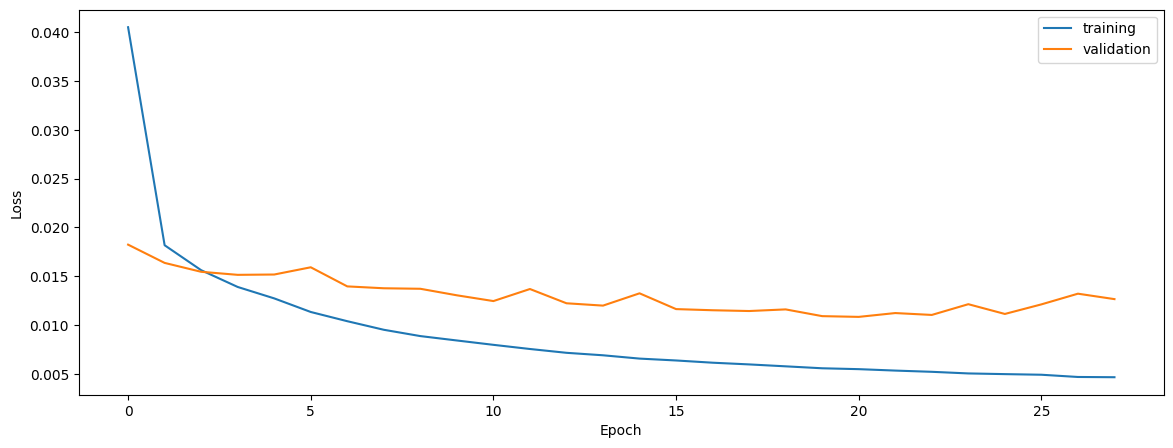

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9624961043029064
0.8305164241211619
0.8393745873033271


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.7688146629169351
0.7663008015248067
0.7731257110661174


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.7692871175821812
0.7711299264521836
0.7766761555382015


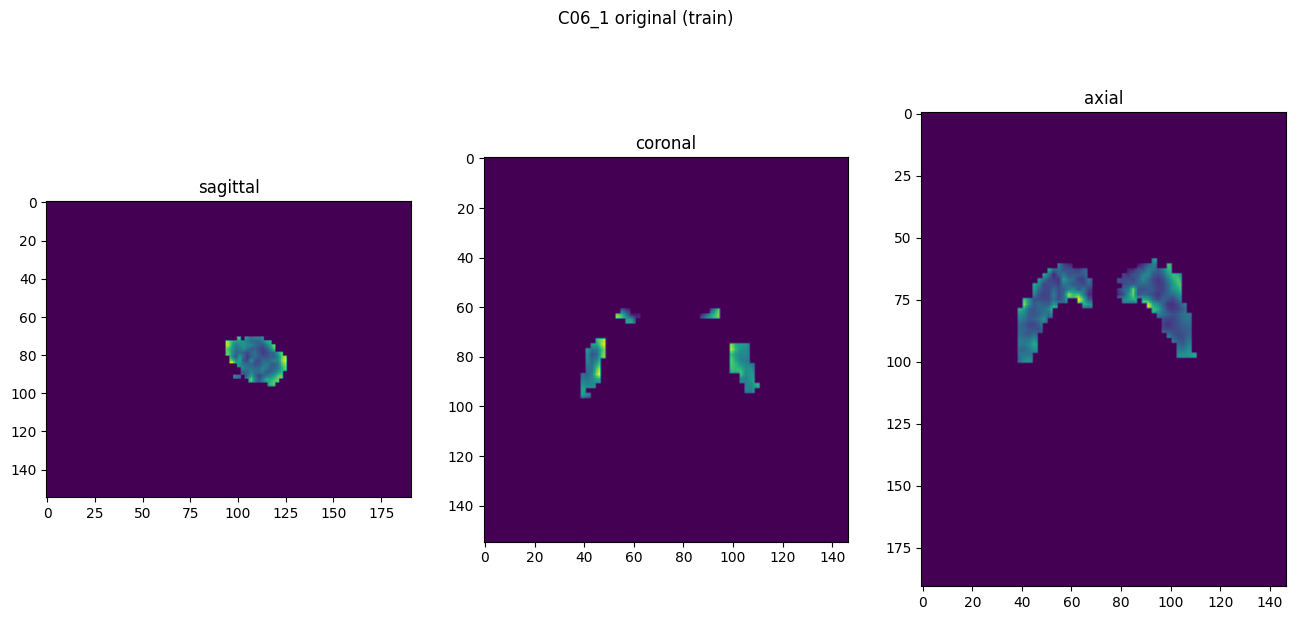

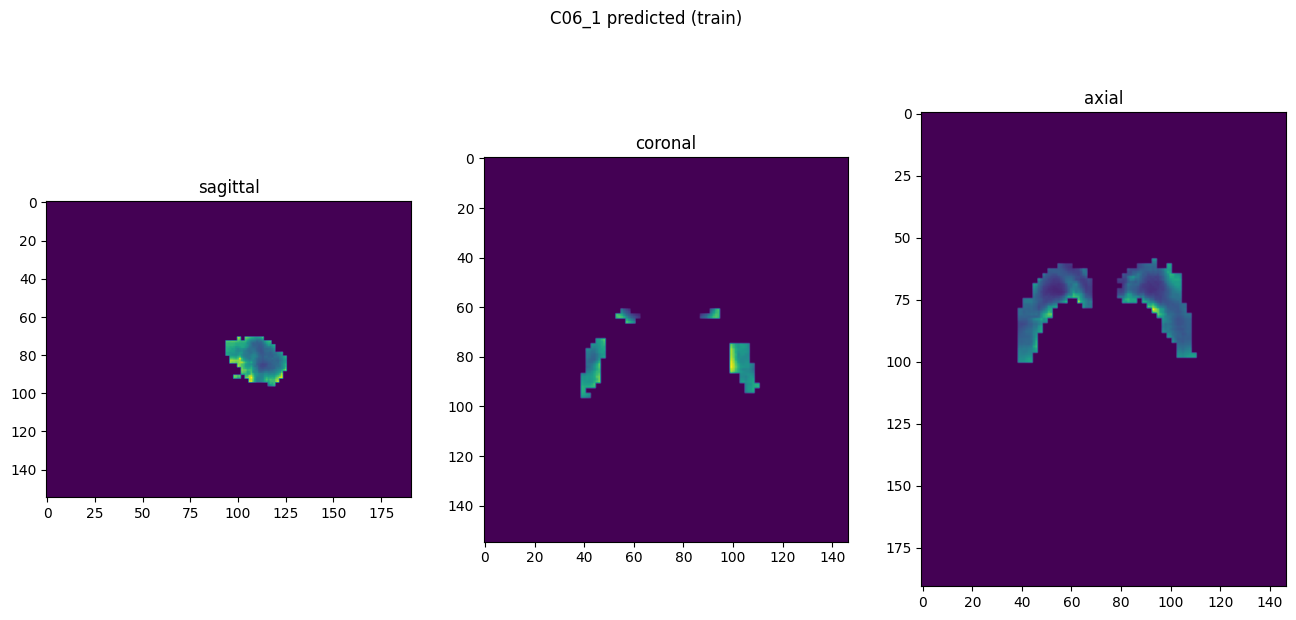

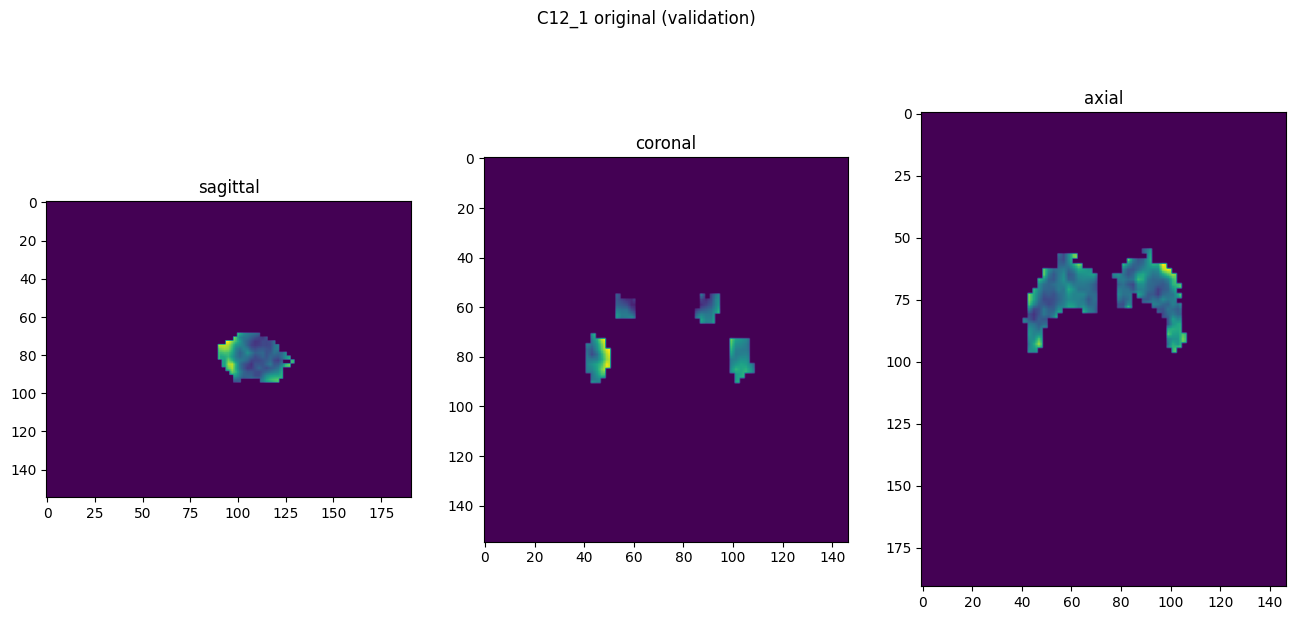

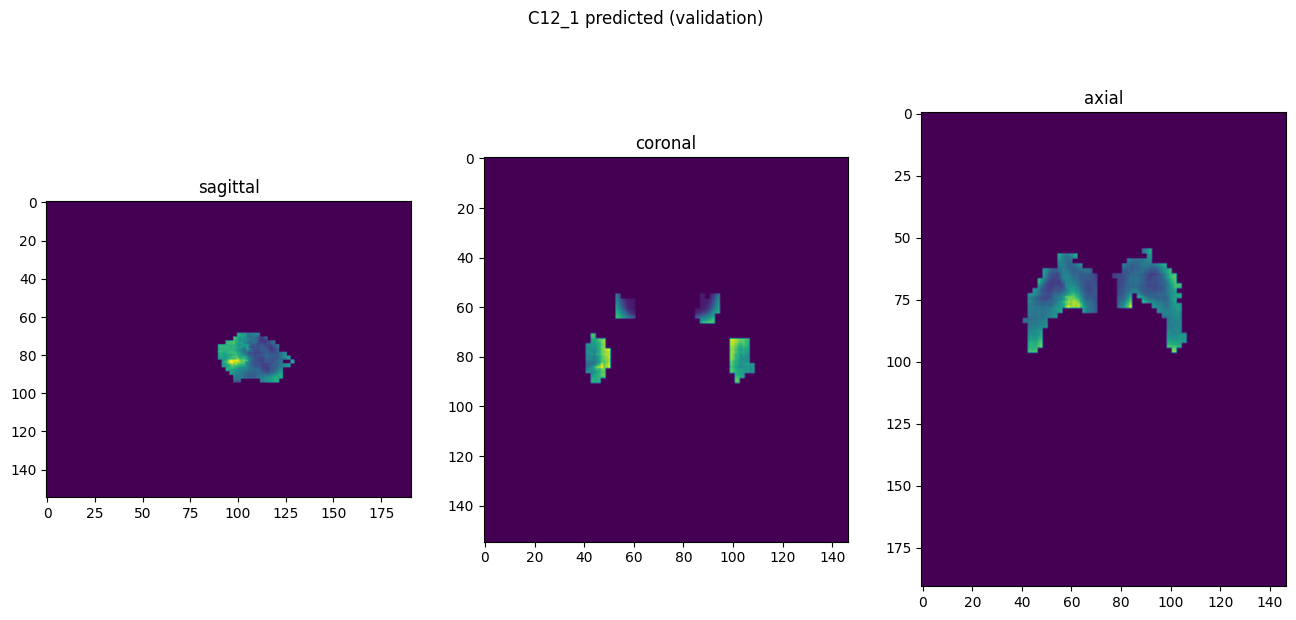

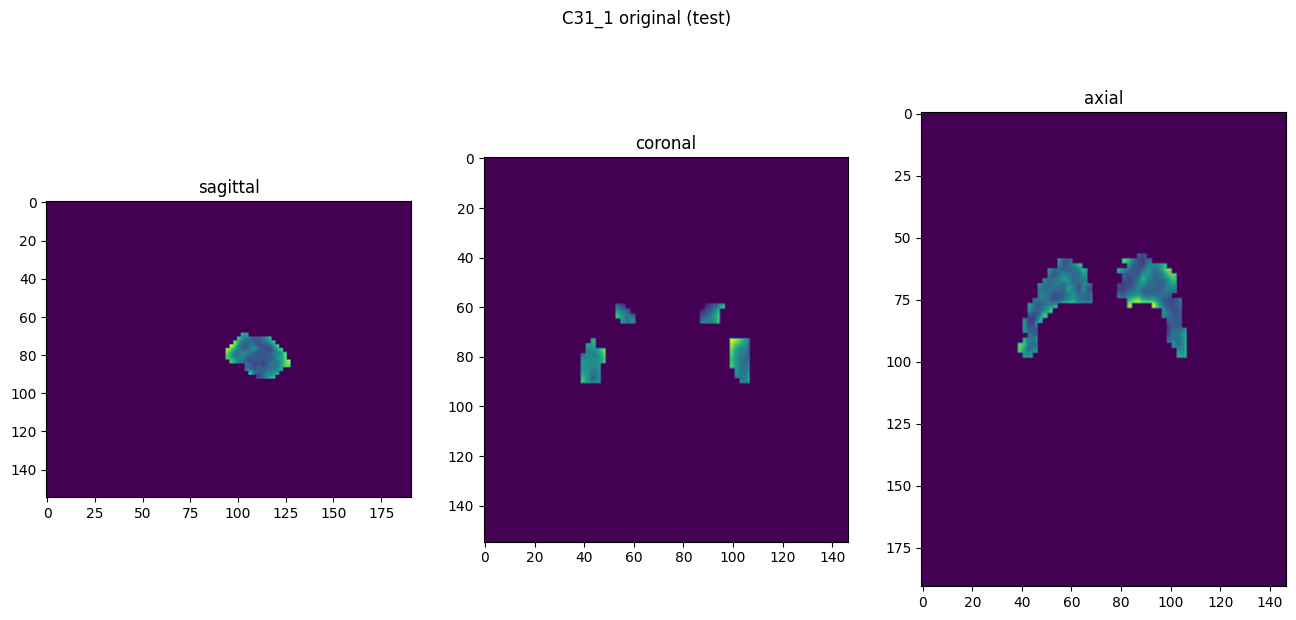

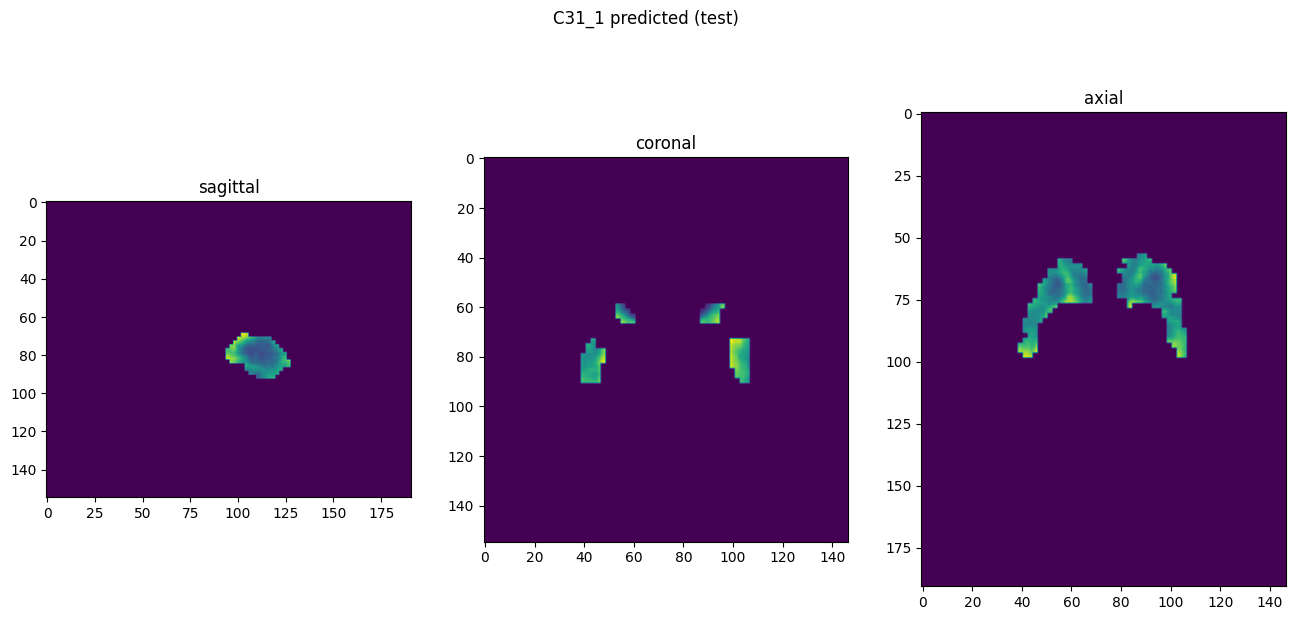

In [10]:
showResults(model, gen, threshold=None, background=False)